In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import sys

# Compute One Run

In [2]:
import numpy as np
from shutil import copyfile
import matplotlib.pyplot as plt
import sys, os
import dill
sys.path.append('../')
import mg_si
import csv
import datetime
from mg_si import plot as mplt

import signal

class timeout:
    def __init__(self, seconds=1, error_message=None):
        self.seconds = seconds
        if error_message is None:
        	self.error_message = 'solution timed out after {}s'.format(seconds)
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

In [29]:
r_i_real = 1220e3

layer_thickness = 100 # m
overturn = 600 # Myr
times = np.linspace(0,4568e6*365.25*24*3600,40000)

## background mantle state
MgNumFp = 0.8
MgNumPv = 0.93
X_MgFeO_b = 0.311
X_SiO2_b = 0.015
## Mantle viscosity
pl = mg_si.planet.Custom()
nu_present = 10**21/pl.params.mantle.rho #[m^2/s]




basefolder = '/media/nknezek/compute_storage/computed_solutions_nature//'
alldatafile = 'all_parameters.m'



In [67]:
T_min_all = 4900
# T_max_all = 6000
T_max_all = 5600
dT = 100

dMg = .01
minMg = 1e-5
maxMg = .05

dO = .01
minO = 1e-5
# maxO = .4
maxO = .3

dSi = .01
minSi = 1e-5
# maxSi = .4
maxSi = .2

T_cmbs = np.linspace(T_min_all,T_max_all,round((T_max_all-T_min_all)/dT)+1)
X_Mgs = np.linspace(minMg,maxMg, round((maxMg-minMg)/dMg)+1)
X_Sis = np.linspace(minSi, maxSi, round((maxSi-minSi)/dSi)+1)
X_Os = np.linspace(minO, maxO, round((maxO-minO)/dO)+1)

vectors = [T_cmbs,X_Mgs,X_Sis,X_Os]

Ntotal = len(T_cmbs)*len(X_Mgs)*len(X_Sis)*len(X_Os)

def get_coords(df,i):
    c = [np.nan]*4
    rtol = 1e-3
    atol = 1e-1
    try:
        c[0] = np.where(np.isclose(df.loc[i,'T_cmb0'],T_cmbs,rtol=rtol,atol=atol))[0][0]
        c[1] = np.where(np.isclose(df.loc[i,'X_Mg_0'],X_Mgs,rtol=rtol,atol=atol))[0][0]
        c[2] = np.where(np.isclose(df.loc[i,'X_Si_0'],X_Sis,rtol=rtol,atol=atol))[0][0]
        c[3] = np.where(np.isclose(df.loc[i,'X_O_0'],X_Os,rtol=rtol,atol=atol))[0][0]
        return tuple(c)
    except:
        return None
    
def coords2values(coords, return_filename=False):
    v = [T_cmbs[coords[0]], X_Mgs[coords[1]], X_Sis[coords[2]], X_Os[coords[3]]]
    if return_filename:
        filename = 'Tc{:.2f}_XM{:.2f}_XS{:.2f}_XO{:.2f}'.format(v[0],v[1],v[2],v[3])
        return v, filename
    else:
        return v
def coords2dict(coords, return_filename=False):
    v = {'T_cmb0':T_cmbs[coords[0]], 'X_Mg_0':X_Mgs[coords[1]], 'X_Si_0':X_Sis[coords[2]], 'X_O_0':X_Os[coords[3]]}
    if return_filename:
        filename = 'Tc{:.2f}_XM{:.2f}_XS{:.2f}_XO{:.2f}'.format(v['T_cmb0'],v['X_Mg_0'],v['X_Si_0'],v['X_O_0'])
        return v, filename
    else:
        return v


In [31]:
def compute_one_run(x,iT): 
    T_cmb0 = T_cmbs[x[0]] 
    X_Mg_0 = X_Mgs[x[1]]
    X_Si_0 = X_Sis[x[2]]
    X_O_0 = X_Os[x[3]]
    times = np.linspace(0,4568e6*365.25*24*3600,40000)

    time = str(datetime.datetime.now())
    print('{} - {:.0f}K - {:.3f}Mg {:.3f}Si {:.3f}O'.format(time, T_cmb0, X_Mg_0, X_Si_0, X_O_0))
    pl = mg_si.planet.Custom()
    pl.reactions._set_layer_thickness(layer_thickness)
    pl.reactions._set_overturn_time(overturn)
    deltaT0 = pl.mantle_layer.get_dT0(T_cmb0)
    T_um0 = T_cmb0-deltaT0
    try:
        filepath = basefolder+ "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(T_cmb0, X_Mg_0, X_Si_0, X_O_0)
        if not os.path.exists(basefolder):
            os.mkdir(basefolder)
        if os.path.exists(filepath+'r_i.m'):
            print('r_i already computed')
            r_i = dill.load(open(filepath+'r_i.m','rb'))
            return r_i
        if os.path.exists(filepath+'data.m'):
            print('already computed')
            try:
                pl,times,solution = dill.load(open(filepath+'data.m','rb'))
                r_i = pl.core_layer.r_i(solution[-1,0], one_off=True)
                dill.dump(r_i, open(filepath+'r_i.m','wb'))
                del pl
                return r_i
            except:
                print('could not load previously computed solution, re-computing now')
        if not os.path.exists(filepath):
            os.mkdir(filepath)
    except:
        print('!!!!! Problem setting up folders',sys.exc_info()[1])
        del pl
        return np.nan
    try:
#         pl.params.reactions.ParamCitationFeO = 'Fischer2015'
#         pl.params.reactions.ParamCitationSiO2 = 'Fischer2015'
#         pl.params.reactions.ParamCitationMgO = 'Badro2015'

        Moles_0 = pl.reactions.compute_Moles_0(X_Mg_0, X_Si_0, X_O_0, T_cmb0)
        x0 = [T_cmb0, T_um0]
        x0 = x0+Moles_0
        pl.params.reactions.Moles_0 = Moles_0
        Mm_b = pl.reactions.mantle.compute_Mm_b(X_MgFeO=X_MgFeO_b, X_SiO2=X_SiO2_b, MgNumFp=MgNumFp, MgNumPv=MgNumPv)
        pl.params.reactions.Mm_b = Mm_b
    except:
        print('Problem with initial mole 0',sys.exc_info()[1])
        del pl
        return np.nan
    try:
        T_present = 1350 # [K]
        nu_old =  nu_present/1e3
        T_old = T_um0
        A,nu0 = pl.mantle_layer.find_arrenhius_params(nu_present, T_present, nu_old, T_old, set_values=True)
    except:
        print('!!!!! Problem setting viscosity',sys.exc_info()[1])
        del pl
        return np.nan
    # plot and store solution info
    timeoutsecs = 120
    try:
        with timeout(seconds=timeoutsecs):
            solution = pl.integrate(times, x0)	
    except TimeoutError as err:
        print('!!!!!!',err,'with {} timesteps'.format(len(times)))
        return np.nan
    except:
        print("!!!!!! Unexpected error during solution:",sys.exc_info()[1])
        return np.nan
    try:
        r_i = pl.core_layer.r_i(solution[-1,0], one_off=True)
    except:
        print('!!!!! Problem computing r_i',sys.exc_info()[1])
        del pl
        return np.nan
    try:
        dill.dump(r_i, open(filepath+'r_i.m','wb'))
        dill.dump((pl, times, solution), open(filepath+'data.m','wb'))
    except:
        print('!!!!! Problem saving solution',sys.exc_info()[1])
        del pl
        return r_i
    try:
        # if the inner-core size is within 10% of real inner-core, compute entropy and heat terms
        if np.abs(r_i/r_i_real-1)<.1:
            print('r_i {:.0f} km within 10%, computing and storing entropy history'.format(r_i/1e3))
            t_N, all_parameters = pl.core_layer.compute_all_parameters(times, solution)
#             mplt.Q_all(pl, t_N, all_parameters, filepath=filepath)
            mplt.E_all(pl, t_N, all_parameters, filepath=filepath)
            dill.dump((t_N, all_parameters), open(filepath+alldatafile,'wb'))
            plt.close('all')
        else:
            print('r_i {:.0f} km not within 10%, entropies not computed'.format(r_i/1e3))
        del pl
        print('==== successfully finished computing')
        return r_i
    except:
        print('!!!!! Problem computing entropies',sys.exc_info()[1])
        return r_i

In [32]:
def inspace(x):
    for xd,vec in zip(x,vectors):
        if xd >len(vec)-1 or xd<0:
            return False
    return True
        

In [33]:
x0 = [7,1,1,1]
r_i = compute_one_run(x0,0)
r_i/1e3

2018-05-03 09:39:09.784672 - 5600K - 0.010Mg 0.010Si 0.010O
r_i already computed


1878.3263519463833

In [34]:
def isvalid(x,dim=0):
    r_i_real = 1220e3
    r_i = compute_one_run(x,dim)
    return np.abs(r_i/r_i_real-1)<.1

In [35]:
isvalid(x0,0)

2018-05-03 09:39:10.721754 - 5600K - 0.010Mg 0.010Si 0.010O
r_i already computed


False

# Multiprocessing Run

In [18]:
from multiprocessing import Process, Queue

In [19]:
def explore_pos(x,dim,dx,valid_solns,computed_solns):
    xp = list(x)
    xp[dim] += dx
    xp = tuple(xp)
    if not inspace(xp):
        return
    if xp in computed_solns:
        return
    computed_solns.add(xp)
    if not isvalid(xp):
        return
    valid_solns.add(xp)
    explore_pos(xp,dim,dx,valid_solns,computed_solns)

def explore_neg(x,dim,dx,valid_solns,computed_solns):
    xm = list(x)
    xm[dim] -= dx
    xm = tuple(xm)
    if not inspace(xm):
        return
    if xm in computed_solns:
        return
    computed_solns.add(xm)
    if not isvalid(xm):
        return
    valid_solns.add(xm)
    explore_neg(xm,dim,dx,valid_solns,computed_solns)

def explore_dim(dim,dx,valid_solns,computed_solns):
    valid_solns0 = set(valid_solns)
    for v in valid_solns0:
        explore_pos(v,dim,dx,valid_solns,computed_solns)
    for v in valid_solns0:
        explore_neg(v,dim,dx,valid_solns,computed_solns)

def multi_explore(dim,dx,valid_solns,computed_solns, q):
    explore_dim(dim,dx,valid_solns,computed_solns)
    q.put([valid_solns,computed_solns])

def run_parallel(dims, dxs, valid_solns, computed_solns):
    qs = []
    ps = []
    for dim in dims:
        qs.append(Queue())
        ps.append(Process(target=multi_explore, args=(dim,dxs[dim],valid_solns,computed_solns,qs[dim])))
        ps[dim].start()
    for dim in dims:
        out = qs[dim].get()    # prints "[42, None, 'hello']"
        valid_solns.update(out[0])
        computed_solns.update(out[1])
        ps[dim].join()

def iter_parallel(dims,dxs,valid_solns,computed_solns, Nmax):
    N = 0
    done = False
    while(not done and N<Nmax):
        N +=1
        Ncomp = len(computed_solns)
        run_parallel(dims,dxs,valid_solns,computed_solns)
        if Ncomp == len(computed_solns):
            done=True
        dill.dump((valid_solns,computed_solns),open(testdir+'solution_coords.m','wb'))
    print('done after {} iters'.format(N))
    print(len(valid_solns),len(computed_solns))
    return valid_solns,computed_solns

In [20]:
Ndim = 4
dims = list(range(Ndim))

dxs = tuple([1]*Ndim)
Nmax = 10

vout, cout = iter_parallel(dims, dxs, valid_solns, computed_solns, Nmax)

2018-05-02 17:52:11.030153 - 5500K - 0.010Mg 0.040Si 0.020O
r_i already computed
2018-05-02 17:52:11.049325 - 5500K - 0.000Mg 0.060Si 0.040O
2018-05-02 17:52:11.048153 - 5600K - 0.010Mg 0.020Si 0.030O
r_i already computed
r_i already computed
2018-05-02 17:52:11.057109 - 5400K - 0.000Mg 0.000Si 0.110O
2018-05-02 17:52:11.058141 - 5500K - 0.010Mg 0.050Si 0.040O
r_i already computed
r_i already computed
2018-05-02 17:52:11.060205 - 5600K - 0.010Mg 0.020Si 0.000O
2018-05-02 17:52:11.061329 - 5600K - 0.000Mg 0.060Si 0.000O
r_i already computed
2018-05-02 17:52:11.062974 - 5600K - 0.000Mg 0.060Si 0.030O
2018-05-02 17:52:11.064378 - 5500K - 0.000Mg 0.060Si 0.060O
r_i already computed
r_i already computed
2018-05-02 17:52:11.076048 - 5600K - 0.000Mg 0.060Si 0.010O
2018-05-02 17:52:11.074330 - 5000K - 0.000Mg 0.000Si 0.110O
r_i already computed
r_i already computed
!!!!!! Unexpected error during solution: dTdt should not be >0., something is wrong.
2018-05-02 17:52:11.082521 - 5500K - 0.000Mg 

r_i already computed
2018-05-02 17:52:11.430694 - 5300K - 0.010Mg 0.000Si 0.070O
r_i already computed
2018-05-02 17:52:11.433494 - 5600K - 0.010Mg 0.040Si 0.010O
r_i already computed
2018-05-02 17:52:11.435899 - 5500K - 0.010Mg 0.020Si 0.030O
r_i already computed
2018-05-02 17:52:11.438178 - 5500K - 0.010Mg 0.000Si 0.090O
r_i already computed
2018-05-02 17:52:11.439701 - 5600K - 0.010Mg 0.040Si 0.020O
r_i already computed
2018-05-02 17:52:11.441538 - 5500K - 0.010Mg 0.020Si 0.060O
r_i already computed
2018-05-02 17:52:11.445017 - 5600K - 0.010Mg 0.050Si 0.020O
r_i already computed
2018-05-02 17:52:11.507186 - 5600K - 0.020Mg 0.050Si 0.060O
r_i already computed
2018-05-02 17:52:11.510295 - 5600K - 0.010Mg 0.030Si 0.070O
2018-05-02 17:52:11.514225 - 5500K - 0.020Mg 0.060Si 0.060O
r_i already computed
r_i already computed
2018-05-02 17:52:11.518584 - 5500K - 0.020Mg 0.050Si 0.070O
2018-05-02 17:52:11.520541 - 5500K - 0.010Mg 0.040Si 0.070O
2018-05-02 17:52:11.520387 - 5600K - 0.010Mg 0.04

2018-05-02 17:52:11.645641 - 5500K - 0.030Mg 0.040Si 0.120O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:52:11.648025 - 5500K - 0.040Mg 0.030Si 0.080O
r_i already computed
2018-05-02 17:52:11.649953 - 5500K - 0.040Mg 0.030Si 0.090O
r_i already computed
2018-05-02 17:52:11.651343 - 5500K - 0.040Mg 0.030Si 0.100O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:52:11.653705 - 5500K - 0.030Mg 0.030Si 0.080O
r_i already computed
2018-05-02 17:52:11.655478 - 5500K - 0.030Mg 0.030Si 0.090O
r_i already computed
2018-05-02 17:52:11.658261 - 5500K - 0.030Mg 0.030Si 0.100O
r_i already computed
2018-05-02 17:52:11.660122 - 5500K - 0.030Mg 0.030Si 0.110O
r_i already computed
2018-05-02 17:52:11.664526 - 5500K - 0.030Mg 0.030Si 0.120O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:52

r_i already computed
2018-05-02 17:52:11.830683 - 5500K - 0.010Mg 0.070Si 0.090O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
r_i already computed
2018-05-02 17:52:11.831682 - 5500K - 0.020Mg 0.080Si 0.070O
r_i already computed
2018-05-02 17:52:11.833573 - 5600K - 0.020Mg 0.030Si 0.100O
2018-05-02 17:52:11.832360 - 5500K - 0.010Mg 0.070Si 0.100O
r_i already computed
r_i already computed
2018-05-02 17:52:11.835498 - 5500K - 0.010Mg 0.070Si 0.110O
2018-05-02 17:52:11.820803 - 5500K - 0.040Mg 0.050Si 0.080O
r_i already computed
r_i already computed
r_i already computed
2018-05-02 17:52:11.836784 - 5500K - 0.040Mg 0.040Si 0.110O
2018-05-02 17:52:11.837365 - 5500K - 0.020Mg 0.060Si 0.110O
2018-05-02 17:52:11.837523 - 5500K - 0.010Mg 0.070Si 0.120O
2018-05-02 17:52:11.838372 - 5600K - 0.030Mg 0.030Si 0.080O
r_i already computed
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.

2018-05-02 17:52:12.008285 - 5600K - 0.030Mg 0.020Si 0.070O
r_i already computed
2018-05-02 17:52:12.016975 - 5600K - 0.030Mg 0.040Si 0.070O
r_i already computed
2018-05-02 17:52:12.018776 - 5600K - 0.020Mg 0.040Si 0.090O
r_i already computed
2018-05-02 17:52:12.020350 - 5600K - 0.010Mg 0.050Si 0.100O
r_i already computed
2018-05-02 17:52:12.024970 - 5500K - 0.010Mg 0.080Si 0.080O
r_i already computed
2018-05-02 17:52:12.037520 - 5600K - 0.010Mg 0.050Si 0.090O
2018-05-02 17:52:12.032488 - 5500K - 0.010Mg 0.080Si 0.090O
r_i already computed
r_i already computed
2018-05-02 17:52:12.038283 - 5500K - 0.010Mg 0.080Si 0.100O
r_i already computed
2018-05-02 17:52:12.046149 - 5600K - 0.020Mg 0.040Si 0.070O
r_i already computed
2018-05-02 17:52:12.048516 - 5600K - 0.020Mg 0.020Si 0.060O
r_i already computed
r_i already computed
2018-05-02 17:52:12.050803 - 5500K - 0.010Mg 0.080Si 0.110O
2018-05-02 17:52:12.051294 - 5500K - 0.030Mg 0.080Si 0.110O
r_i already computed
r_i already computed
2018-05

2018-05-02 17:52:12.156262 - 5400K - 0.040Mg 0.020Si 0.070O
r_i already computed
r_i already computed
2018-05-02 17:52:12.157264 - 5500K - 0.020Mg 0.000Si 0.090O
r_i already computed
2018-05-02 17:52:12.158423 - 5500K - 0.030Mg 0.020Si 0.090O
r_i already computed
r_i already computed
2018-05-02 17:52:12.157940 - 5400K - 0.020Mg 0.040Si 0.120O
2018-05-02 17:52:12.160767 - 5500K - 0.030Mg 0.010Si 0.090O
2018-05-02 17:52:12.164212 - 5300K - 0.020Mg 0.040Si 0.120O
r_i already computed
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:52:12.170640 - 5400K - 0.010Mg 0.070Si 0.060O
r_i already computed
2018-05-02 17:52:12.172831 - 5500K - 0.030Mg 0.000Si 0.090O
2018-05-02 17:52:12.172355 - 5400K - 0.020Mg 0.040Si 0.100O
r_i already computed
2018-05-02 17:52:12.174604 - 5500K - 0.050Mg 0.020Si 0.080O
r_i already computed
r_i already computed
2018-05-02 17:52:12.176952 - 5500K - 0.050Mg 0.010Si 0.080O
2018-05-02 17:52:12.1770

r_i already computed
2018-05-02 17:52:12.465246 - 5600K - 0.020Mg 0.140Si 0.060O
2018-05-02 17:52:12.467150 - 5500K - 0.020Mg 0.090Si 0.130O
2018-05-02 17:52:12.466287 - 5600K - 0.040Mg 0.060Si 0.050O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
r_i already computed
2018-05-02 17:52:12.470717 - 5600K - 0.030Mg 0.140Si 0.060O
r_i already computed
2018-05-02 17:52:12.472934 - 5500K - 0.030Mg 0.090Si 0.120O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:52:12.474895 - 5500K - 0.040Mg 0.020Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:52:12.478145 - 5600K - 0.020Mg 0.010Si 0.060O
r_i already computed
r_i already computed
2018-05-02 17:52:12.466336 - 5600K - 0.000Mg 0.070Si 0.070O
r_i already computed
r_i already computed
2018-05-02 17:52:12.486993 - 5600K - 0.020Mg 0.070Si 0.

r_i already computed
2018-05-02 17:52:12.599056 - 5400K - 0.020Mg 0.040Si 0.130O
2018-05-02 17:52:12.599835 - 5600K - 0.030Mg 0.100Si 0.060O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
r_i already computed
2018-05-02 17:52:12.602398 - 5600K - 0.040Mg 0.100Si 0.060O
2018-05-02 17:52:12.601598 - 5600K - 0.010Mg 0.160Si 0.070O
r_i already computed
2018-05-02 17:52:12.603869 - 5600K - 0.010Mg 0.160Si 0.080O
r_i already computed
r_i already computed
2018-05-02 17:52:12.605560 - 5500K - 0.020Mg 0.030Si 0.140O
2018-05-02 17:52:12.604707 - 5600K - 0.010Mg 0.060Si 0.120O
2018-05-02 17:52:12.606405 - 5600K - 0.050Mg 0.030Si 0.050O
r_i already computed
r_i already computed
2018-05-02 17:52:12.608218 - 5500K - 0.020Mg 0.030Si 0.130O
r_i already computed
2018-05-02 17:52:12.610710 - 5600K - 0.050Mg 0.040Si 0.060O
r_i already computed
r_i already computed
2018-05-02 17:52:12.612182 - 5600K - 0.050Mg 0.050Si 0.060O
r_i already computed
201

2018-05-02 17:52:12.735631 - 5500K - 0.000Mg 0.130Si 0.070O
r_i already computed
r_i already computed
2018-05-02 17:52:12.736674 - 5600K - 0.010Mg 0.010Si 0.080O
2018-05-02 17:52:12.718133 - 5600K - 0.030Mg 0.060Si 0.070O
r_i already computed
r_i already computed
2018-05-02 17:52:12.738211 - 5600K - 0.040Mg 0.060Si 0.070O
r_i already computed
2018-05-02 17:52:12.739009 - 5600K - 0.020Mg 0.020Si 0.110O
r_i already computed
2018-05-02 17:52:12.737107 - 5500K - 0.010Mg 0.090Si 0.140O
2018-05-02 17:52:12.740483 - 5600K - 0.010Mg 0.090Si 0.100O
r_i already computed
r_i already computed
2018-05-02 17:52:12.743302 - 5600K - 0.020Mg 0.020Si 0.140O
2018-05-02 17:52:12.741811 - 5500K - 0.010Mg 0.100Si 0.140O
r_i already computed
2018-05-02 17:52:12.752128 - 5500K - 0.010Mg 0.110Si 0.140O
r_i already computed
2018-05-02 17:52:12.748788 - 5600K - 0.050Mg 0.060Si 0.070O
r_i already computed
2018-05-02 17:52:12.761593 - 5600K - 0.010Mg 0.090Si 0.090O
r_i already computed
r_i already computed
2018-05

2018-05-02 17:52:12.958356 - 5400K - 0.000Mg 0.040Si 0.120O
r_i already computed
2018-05-02 17:52:12.969629 - 5500K - 0.000Mg 0.080Si 0.130O
r_i already computed
2018-05-02 17:52:12.971133 - 5500K - 0.000Mg 0.080Si 0.100O
r_i already computed
2018-05-02 17:52:12.972506 - 5600K - 0.000Mg 0.160Si 0.060O
r_i already computed
2018-05-02 17:52:12.973978 - 5600K - 0.000Mg 0.110Si 0.060O
r_i already computed
2018-05-02 17:52:12.977315 - 5600K - 0.030Mg 0.050Si 0.100O
r_i already computed
2018-05-02 17:52:12.984895 - 5500K - 0.010Mg 0.020Si 0.100O
r_i already computed
r_i already computed
2018-05-02 17:52:12.988674 - 5500K - 0.000Mg 0.090Si 0.080O
r_i already computed
2018-05-02 17:52:12.992653 - 5600K - 0.020Mg 0.100Si 0.120O
r_i already computed
2018-05-02 17:52:12.996102 - 5500K - 0.010Mg 0.020Si 0.120O
2018-05-02 17:52:12.996232 - 5600K - 0.010Mg 0.060Si 0.080O
r_i already computed
r_i already computed
2018-05-02 17:52:13.000696 - 5400K - 0.020Mg 0.010Si 0.130O
r_i already computed
2018-05

r_i already computed
2018-05-02 17:52:13.258820 - 5500K - 0.010Mg 0.180Si 0.060O
r_i already computed
2018-05-02 17:52:13.260618 - 5400K - 0.030Mg 0.060Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:52:13.270017 - 5400K - 0.040Mg 0.020Si 0.080O
r_i already computed
2018-05-02 17:52:13.277014 - 5400K - 0.010Mg 0.070Si 0.120O
r_i already computed
2018-05-02 17:52:13.282794 - 5400K - 0.040Mg 0.020Si 0.060O
r_i already computed
2018-05-02 17:52:13.284437 - 5400K - 0.010Mg 0.070Si 0.100O
r_i already computed
2018-05-02 17:52:13.285980 - 5400K - 0.020Mg 0.000Si 0.090O
r_i already computed
2018-05-02 17:52:13.288636 - 5500K - 0.010Mg 0.130Si 0.060O
r_i already computed
2018-05-02 17:52:13.289911 - 5400K - 0.020Mg 0.080Si 0.110O
r_i already computed
2018-05-02 17:52:13.292669 - 5400K - 0.020Mg 0.070Si 0.100O
r_i already computed
2018-05-02 17:52:13.294902 - 5400K - 0.020Mg 0.070Si 0.120O
Problem with initial mol

r_i already computed
2018-05-02 17:53:22.785398 - 5600K - 0.010Mg 0.130Si 0.100O
r_i already computed
2018-05-02 17:53:22.789550 - 5600K - 0.010Mg 0.130Si 0.110O
r_i already computed
2018-05-02 17:53:22.798618 - 5600K - 0.010Mg 0.130Si 0.120O
r_i already computed
2018-05-02 17:53:22.804965 - 5600K - 0.010Mg 0.080Si 0.080O
r_i already computed
2018-05-02 17:53:22.810591 - 5500K - 0.010Mg 0.010Si 0.090O
r_i already computed
2018-05-02 17:53:22.813300 - 5500K - 0.010Mg 0.010Si 0.100O
r_i already computed
2018-05-02 17:53:22.815627 - 5500K - 0.010Mg 0.010Si 0.110O
r_i already computed
2018-05-02 17:53:22.818388 - 5500K - 0.010Mg 0.010Si 0.120O
r_i already computed
2018-05-02 17:53:22.820366 - 5500K - 0.010Mg 0.010Si 0.130O
r_i already computed
2018-05-02 17:53:22.822458 - 5500K - 0.010Mg 0.010Si 0.140O
r_i already computed
2018-05-02 17:53:22.824800 - 5500K - 0.010Mg 0.010Si 0.150O
r_i already computed
2018-05-02 17:53:22.826735 - 5500K - 0.010Mg 0.010Si 0.160O
r_i already computed
2018-05

2018-05-02 17:55:09.038013 - 5600K - 0.010Mg 0.170Si 0.040O
r_i 1648 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 17:55:14.583049 - 5600K - 0.010Mg 0.080Si 0.050O
r_i already computed
2018-05-02 17:55:14.588156 - 5600K - 0.010Mg 0.030Si 0.050O
r_i already computed
2018-05-02 17:55:14.590714 - 5600K - 0.010Mg 0.160Si 0.050O
r_i 1290 km within 10%, computing and storing entropy history
==== successfully finished computing
2018-05-02 17:55:22.750622 - 5600K - 0.010Mg 0.160Si 0.040O
r_i 1637 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 17:55:28.529901 - 5600K - 0.010Mg 0.110Si 0.050O
r_i already computed
2018-05-02 17:55:28.544546 - 5600K - 0.010Mg 0.020Si 0.050O
r_i 1375 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 17:55:39.805243 - 5600K - 0.010Mg 0.190Si 0.050O
r_i 1306 km within 10%, computing and storing entropy history
==== successfully finished compu

r_i already computed
2018-05-02 17:56:58.180729 - 5500K - 0.000Mg 0.100Si 0.150O
r_i 965 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 17:56:59.872807 - 5600K - 0.010Mg 0.010Si 0.130O
r_i already computed
2018-05-02 17:56:59.888498 - 5600K - 0.010Mg 0.090Si 0.150O
r_i already computed
2018-05-02 17:56:59.904871 - 5600K - 0.000Mg 0.090Si 0.120O
r_i already computed
2018-05-02 17:56:59.922370 - 5600K - 0.000Mg 0.090Si 0.090O
r_i already computed
2018-05-02 17:56:59.938069 - 5600K - 0.010Mg 0.100Si 0.130O
r_i already computed
2018-05-02 17:57:00.001053 - 5600K - 0.010Mg 0.100Si 0.140O
r_i already computed
2018-05-02 17:57:00.017046 - 5600K - 0.010Mg 0.100Si 0.110O
r_i already computed
2018-05-02 17:57:00.022300 - 5600K - 0.010Mg 0.140Si 0.140O
r_i already computed
2018-05-02 17:57:00.033389 - 5600K - 0.000Mg 0.080Si 0.100O
r_i already computed
2018-05-02 17:57:00.043617 - 5600K - 0.000Mg 0.080Si 0.090O
r_i already computed
2018-05-02 17:57:00.06

2018-05-02 17:57:25.715206 - 5600K - 0.020Mg 0.170Si 0.090O
==== successfully finished computing
2018-05-02 17:57:26.428784 - 5500K - 0.000Mg 0.120Si 0.180O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:57:26.446892 - 5600K - 0.000Mg 0.130Si 0.070O
r_i already computed
2018-05-02 17:57:26.471329 - 5600K - 0.000Mg 0.130Si 0.080O
r_i already computed
2018-05-02 17:57:26.483537 - 5600K - 0.030Mg 0.080Si 0.080O
r_i already computed
2018-05-02 17:57:26.490943 - 5600K - 0.030Mg 0.080Si 0.090O
r_i already computed
2018-05-02 17:57:26.500558 - 5600K - 0.030Mg 0.080Si 0.100O
r_i already computed
2018-05-02 17:57:26.536008 - 5600K - 0.030Mg 0.080Si 0.110O
r_i already computed
2018-05-02 17:57:26.575125 - 5600K - 0.030Mg 0.080Si 0.120O
r_i already computed
2018-05-02 17:57:26.607151 - 5600K - 0.030Mg 0.080Si 0.130O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018

r_i 1257 km within 10%, computing and storing entropy history
r_i 1453 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 17:58:13.422717 - 5400K - 0.000Mg 0.120Si 0.070O
r_i already computed
2018-05-02 17:58:13.439910 - 5500K - 0.010Mg 0.180Si 0.140O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:58:13.446589 - 5500K - 0.010Mg 0.180Si 0.130O
r_i 1341 km within 10%, computing and storing entropy history
==== successfully finished computing
2018-05-02 17:58:18.843752 - 5500K - 0.000Mg 0.120Si 0.160O
r_i already computed
2018-05-02 17:58:18.870867 - 5500K - 0.000Mg 0.130Si 0.160O
r_i already computed
2018-05-02 17:58:18.880608 - 5500K - 0.000Mg 0.140Si 0.160O
r_i already computed
2018-05-02 17:58:18.892410 - 5500K - 0.000Mg 0.150Si 0.160O
r_i already computed
2018-05-02 17:58:18.905059 - 5500K - 0.000Mg 0.160Si 0.160O
==== successfully finished computing
2018-05-02 17:58:20.808

r_i 1271 km within 10%, computing and storing entropy history
r_i 1476 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 17:59:10.675789 - 5400K - 0.010Mg 0.110Si 0.110O
r_i already computed
2018-05-02 17:59:10.705978 - 5500K - 0.040Mg 0.050Si 0.050O
r_i already computed
2018-05-02 17:59:10.740296 - 5400K - 0.010Mg 0.110Si 0.140O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:59:10.752139 - 5400K - 0.000Mg 0.060Si 0.120O
r_i already computed
2018-05-02 17:59:10.757719 - 5400K - 0.010Mg 0.120Si 0.140O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 17:59:10.770655 - 5500K - 0.020Mg 0.110Si 0.070O
r_i already computed
2018-05-02 17:59:10.797168 - 5400K - 0.000Mg 0.060Si 0.100O
r_i already computed
2018-05-02 17:59:10.814206 - 5500K - 0.050Mg 0.050Si 0.060O
r_i already computed
2018-05-02 17:59:10.829109 - 540

==== successfully finished computing
2018-05-02 18:00:15.152727 - 5500K - 0.010Mg 0.190Si 0.080O
r_i 1293 km within 10%, computing and storing entropy history
r_i 1118 km within 10%, computing and storing entropy history
==== successfully finished computing
2018-05-02 18:00:22.007970 - 5600K - 0.030Mg 0.200Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:00:22.021438 - 5600K - 0.020Mg 0.110Si 0.100O
r_i already computed
2018-05-02 18:00:22.035425 - 5600K - 0.030Mg 0.110Si 0.100O
r_i already computed
2018-05-02 18:00:22.048704 - 5600K - 0.040Mg 0.110Si 0.100O
r_i already computed
2018-05-02 18:00:22.073016 - 5600K - 0.050Mg 0.110Si 0.100O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:00:22.081187 - 5600K - 0.020Mg 0.200Si 0.140O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2

r_i already computed
2018-05-02 18:01:07.156913 - 5500K - 0.010Mg 0.030Si 0.110O
r_i already computed
2018-05-02 18:01:07.173761 - 5500K - 0.000Mg 0.090Si 0.110O
r_i already computed
2018-05-02 18:01:07.179422 - 5500K - 0.000Mg 0.100Si 0.110O
r_i already computed
2018-05-02 18:01:07.191341 - 5500K - 0.000Mg 0.110Si 0.110O
r_i 1103 km within 10%, computing and storing entropy history
r_i 1482 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:01:11.287276 - 5400K - 0.010Mg 0.140Si 0.140O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:01:11.298818 - 5400K - 0.000Mg 0.080Si 0.100O
r_i already computed
2018-05-02 18:01:11.305312 - 5500K - 0.010Mg 0.180Si 0.100O
r_i 1338 km within 10%, computing and storing entropy history
r_i 1295 km within 10%, computing and storing entropy history
==== successfully finished computing
2018-05-02 18:01:16.864103 - 5600K - 0.000Mg 0.160Si 0.140

r_i already computed
2018-05-02 18:01:57.439076 - 5400K - 0.000Mg 0.110Si 0.100O
r_i already computed
2018-05-02 18:01:57.445677 - 5400K - 0.010Mg 0.110Si 0.120O
r_i already computed
2018-05-02 18:01:57.454447 - 5400K - 0.000Mg 0.110Si 0.070O
r_i already computed
2018-05-02 18:01:57.465107 - 5400K - 0.010Mg 0.120Si 0.110O
r_i already computed
2018-05-02 18:01:57.474499 - 5400K - 0.000Mg 0.060Si 0.130O
r_i already computed
2018-05-02 18:01:57.480430 - 5400K - 0.010Mg 0.120Si 0.130O
r_i already computed
2018-05-02 18:01:57.489262 - 5400K - 0.000Mg 0.060Si 0.080O
r_i already computed
2018-05-02 18:01:57.511932 - 5400K - 0.000Mg 0.060Si 0.110O
r_i already computed
2018-05-02 18:01:57.531710 - 5500K - 0.000Mg 0.180Si 0.060O
r_i 1298 km within 10%, computing and storing entropy history
r_i 1258 km within 10%, computing and storing entropy history
==== successfully finished computing
2018-05-02 18:02:01.412931 - 5600K - 0.000Mg 0.170Si 0.070O
r_i 1406 km not within 10%, entropies not computed

r_i already computed
2018-05-02 18:03:01.137133 - 5600K - 0.020Mg 0.180Si 0.100O
r_i already computed
2018-05-02 18:03:01.164353 - 5600K - 0.020Mg 0.190Si 0.100O
r_i 1352 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:03:01.361837 - 5600K - 0.020Mg 0.120Si 0.080O
r_i already computed
2018-05-02 18:03:01.406651 - 5600K - 0.030Mg 0.120Si 0.080O
r_i already computed
2018-05-02 18:03:01.432900 - 5600K - 0.040Mg 0.120Si 0.080O
r_i already computed
2018-05-02 18:03:01.446089 - 5600K - 0.020Mg 0.120Si 0.110O
r_i already computed
2018-05-02 18:03:01.458637 - 5600K - 0.030Mg 0.120Si 0.110O
r_i already computed
2018-05-02 18:03:01.489106 - 5600K - 0.040Mg 0.120Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:03:01.540833 - 5500K - 0.020Mg 0.010Si 0.160O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18

r_i 1110 km within 10%, computing and storing entropy history
r_i 1407 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:04:01.731693 - 5400K - 0.010Mg 0.020Si 0.110O
r_i already computed
2018-05-02 18:04:01.745105 - 5300K - 0.010Mg 0.020Si 0.110O
r_i already computed
2018-05-02 18:04:01.773905 - 5500K - 0.020Mg 0.130Si 0.060O
==== successfully finished computing
2018-05-02 18:04:02.231169 - 5600K - 0.000Mg 0.170Si 0.150O
r_i 1357 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:04:03.191942 - 5600K - 0.050Mg 0.070Si 0.050O
r_i already computed
2018-05-02 18:04:03.199049 - 5600K - 0.020Mg 0.190Si 0.120O
r_i already computed
2018-05-02 18:04:03.204716 - 5600K - 0.030Mg 0.190Si 0.120O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:04:03.217860 - 5600K - 0.020Mg 0.100Si 0.080O
r_i already computed
2018-05-02 18:04:03.239452 - 5600K

2018-05-02 18:04:39.921579 - 5600K - 0.030Mg 0.160Si 0.120O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:04:39.932410 - 5600K - 0.030Mg 0.150Si 0.070O
r_i already computed
2018-05-02 18:04:39.946646 - 5600K - 0.020Mg 0.160Si 0.100O
r_i already computed
2018-05-02 18:04:39.954751 - 5600K - 0.030Mg 0.160Si 0.100O
r_i 1391 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:04:42.136050 - 5400K - 0.000Mg 0.080Si 0.140O
r_i already computed
2018-05-02 18:04:42.151229 - 5400K - 0.000Mg 0.080Si 0.130O
r_i already computed
2018-05-02 18:04:42.164112 - 5400K - 0.000Mg 0.070Si 0.080O
r_i already computed
2018-05-02 18:04:42.167409 - 5500K - 0.050Mg 0.060Si 0.070O
r_i already computed
2018-05-02 18:04:42.177314 - 5400K - 0.000Mg 0.070Si 0.130O
r_i already computed
2018-05-02 18:04:42.181461 - 5400K - 0.000Mg 0.070Si 0.140O
r_i already computed
2018-05-02 18:04:42.188799 - 5500K - 0

==== successfully finished computing
2018-05-02 18:05:44.236845 - 5600K - 0.000Mg 0.180Si 0.130O
r_i 1126 km within 10%, computing and storing entropy history
r_i 1418 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:05:51.207597 - 5500K - 0.010Mg 0.200Si 0.130O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:05:51.224728 - 5500K - 0.010Mg 0.110Si 0.080O
r_i already computed
2018-05-02 18:05:51.234449 - 5500K - 0.020Mg 0.080Si 0.060O
r_i already computed
2018-05-02 18:05:51.258952 - 5400K - 0.010Mg 0.130Si 0.120O
r_i already computed
2018-05-02 18:05:51.266282 - 5500K - 0.020Mg 0.120Si 0.070O
r_i already computed
2018-05-02 18:05:51.274252 - 5400K - 0.010Mg 0.130Si 0.110O
r_i already computed
2018-05-02 18:05:51.280792 - 5400K - 0.000Mg 0.010Si 0.120O
r_i already computed
2018-05-02 18:05:51.295298 - 5500K - 0.010Mg 0.110Si 0.070O
r_i already computed
2018-05-02 18:05:51.

r_i already computed
2018-05-02 18:06:56.688804 - 5600K - 0.000Mg 0.190Si 0.130O
r_i 1154 km within 10%, computing and storing entropy history
==== successfully finished computing
2018-05-02 18:07:03.541459 - 5600K - 0.000Mg 0.190Si 0.100O
r_i 1135 km within 10%, computing and storing entropy history
==== successfully finished computing
2018-05-02 18:07:08.790822 - 5600K - 0.000Mg 0.140Si 0.110O
r_i 1149 km within 10%, computing and storing entropy history
==== successfully finished computing
2018-05-02 18:07:14.044790 - 5600K - 0.000Mg 0.190Si 0.110O
r_i already computed
2018-05-02 18:07:14.051459 - 5600K - 0.000Mg 0.190Si 0.120O
r_i 1082 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:07:14.859629 - 5500K - 0.000Mg 0.100Si 0.130O
r_i already computed
2018-05-02 18:07:14.867060 - 5500K - 0.000Mg 0.100Si 0.140O
r_i already computed
2018-05-02 18:07:14.872546 - 5500K - 0.000Mg 0.100Si 0.110O
r_i already computed
2018-05-02 18:07:14.884795 - 5

2018-05-02 18:08:04.416283 - 5600K - 0.040Mg 0.070Si 0.070O
r_i already computed
2018-05-02 18:08:04.420836 - 5600K - 0.040Mg 0.070Si 0.080O
r_i already computed
2018-05-02 18:08:04.428535 - 5600K - 0.040Mg 0.070Si 0.090O
r_i already computed
2018-05-02 18:08:04.442273 - 5600K - 0.040Mg 0.070Si 0.100O
r_i 1354 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:08:05.710469 - 5600K - 0.000Mg 0.160Si 0.050O
r_i 1194 km within 10%, computing and storing entropy history
r_i 1586 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:08:14.921811 - 5600K - 0.000Mg 0.120Si 0.090O
r_i already computed
2018-05-02 18:08:14.935051 - 5600K - 0.000Mg 0.200Si 0.100O
==== successfully finished computing
2018-05-02 18:08:17.749562 - 5600K - 0.040Mg 0.070Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:08:17.759095 - 5600K - 0.000Mg 0.120Si 0.

2018-05-02 18:09:01.474142 - 5600K - 0.020Mg 0.090Si 0.050O
r_i already computed
2018-05-02 18:09:01.475585 - 5600K - 0.020Mg 0.090Si 0.040O
r_i 1560 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:09:08.648910 - 5500K - 0.050Mg 0.000Si 0.040O
r_i already computed
2018-05-02 18:09:08.654558 - 5500K - 0.000Mg 0.120Si 0.060O
r_i already computed
2018-05-02 18:09:08.657761 - 5600K - 0.000Mg 0.130Si 0.050O
r_i already computed
2018-05-02 18:09:08.660868 - 5600K - 0.020Mg 0.140Si 0.050O
r_i already computed
2018-05-02 18:09:08.663947 - 5600K - 0.020Mg 0.140Si 0.040O
r_i already computed
2018-05-02 18:09:08.667933 - 5600K - 0.050Mg 0.020Si 0.040O
r_i already computed
2018-05-02 18:09:08.670194 - 5600K - 0.040Mg 0.050Si 0.040O
r_i already computed
2018-05-02 18:09:08.680655 - 5600K - 0.050Mg 0.050Si 0.050O
r_i already computed
2018-05-02 18:09:08.682906 - 5600K - 0.050Mg 0.050Si 0.040O
r_i already computed
2018-05-02 18:09:08.687127 - 5600K - 0.040

2018-05-02 18:09:21.354935 - 5600K - 0.050Mg 0.080Si 0.090O
r_i already computed
2018-05-02 18:09:21.356507 - 5600K - 0.010Mg 0.180Si 0.160O
2018-05-02 18:09:21.351486 - 5400K - 0.010Mg 0.050Si 0.160O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:09:21.359566 - 5600K - 0.040Mg 0.110Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:09:21.361572 - 5500K - 0.010Mg 0.100Si 0.180O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:09:21.363249 - 5500K - 0.010Mg 0.130Si 0.160O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:09:21.360481 - 5500K - 0.000Mg 0.130Si 0.180O
Problem with initial mole 0 i

2018-05-02 18:09:38.331424 - 5500K - 0.000Mg 0.150Si 0.170O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:09:38.389305 - 5600K - 0.040Mg 0.090Si 0.090O
r_i already computed
2018-05-02 18:09:38.406151 - 5600K - 0.040Mg 0.090Si 0.100O
r_i already computed
2018-05-02 18:09:38.433077 - 5600K - 0.040Mg 0.090Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:09:38.471569 - 5400K - 0.030Mg 0.000Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:09:38.492763 - 5500K - 0.000Mg 0.160Si 0.170O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:09:38.503689 - 5600K - 0.040Mg 0.110Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-

r_i already computed
2018-05-02 18:10:11.169615 - 5400K - 0.000Mg 0.050Si 0.180O
r_i already computed
2018-05-02 18:10:11.175404 - 5400K - 0.000Mg 0.060Si 0.180O
r_i already computed
2018-05-02 18:10:11.180789 - 5400K - 0.000Mg 0.070Si 0.180O
r_i already computed
2018-05-02 18:10:11.216877 - 5400K - 0.010Mg 0.030Si 0.110O
r_i already computed
2018-05-02 18:10:11.252937 - 5500K - 0.000Mg 0.030Si 0.160O
r_i already computed
2018-05-02 18:10:11.266756 - 5500K - 0.000Mg 0.040Si 0.160O
r_i already computed
2018-05-02 18:10:11.303933 - 5500K - 0.010Mg 0.030Si 0.180O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:10:11.318926 - 5400K - 0.010Mg 0.030Si 0.150O
r_i already computed
2018-05-02 18:10:11.330929 - 5400K - 0.010Mg 0.020Si 0.150O
r_i 1079 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:10:16.741447 - 5600K - 0.000Mg 0.110Si 0.140O
r_i already computed
2018-05-02 18:10:

r_i already computed
2018-05-02 18:11:14.572025 - 5500K - 0.000Mg 0.180Si 0.090O
r_i 1386 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:11:20.053627 - 5500K - 0.020Mg 0.190Si 0.090O
r_i 1496 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:11:24.869759 - 5500K - 0.020Mg 0.150Si 0.080O
r_i already computed
2018-05-02 18:11:24.874920 - 5300K - 0.020Mg 0.000Si 0.110O
r_i already computed
2018-05-02 18:11:24.879711 - 5500K - 0.030Mg 0.150Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:11:24.885662 - 5500K - 0.030Mg 0.110Si 0.080O
r_i already computed
2018-05-02 18:11:24.894466 - 5400K - 0.000Mg 0.100Si 0.170O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:11:24.900191 - 5500K - 0.000Mg 0.150Si 0.100O
r_i already computed
2018-05-02 18:11:24.908160 

r_i already computed
2018-05-02 18:12:33.494315 - 5300K - 0.010Mg 0.040Si 0.130O
r_i already computed
2018-05-02 18:12:33.496045 - 5500K - 0.030Mg 0.090Si 0.100O
r_i already computed
2018-05-02 18:12:33.497485 - 5500K - 0.000Mg 0.160Si 0.080O
r_i 1375 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:12:37.705855 - 5400K - 0.000Mg 0.120Si 0.120O
r_i already computed
2018-05-02 18:12:37.713892 - 5500K - 0.000Mg 0.200Si 0.090O
r_i 1397 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:12:42.266669 - 5500K - 0.030Mg 0.130Si 0.110O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:12:42.272154 - 5500K - 0.020Mg 0.100Si 0.050O
r_i already computed
2018-05-02 18:12:42.278562 - 5500K - 0.000Mg 0.170Si 0.140O
r_i 1357 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:12:48.220891 - 5500K - 0.020Mg 

Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:14:09.205195 - 5500K - 0.030Mg 0.100Si 0.050O
r_i already computed
2018-05-02 18:14:09.225197 - 5500K - 0.030Mg 0.100Si 0.090O
r_i already computed
2018-05-02 18:14:09.233640 - 5400K - 0.010Mg 0.020Si 0.160O
r_i already computed
2018-05-02 18:14:09.239933 - 5400K - 0.000Mg 0.090Si 0.150O
r_i already computed
2018-05-02 18:14:09.250123 - 5500K - 0.030Mg 0.050Si 0.050O
r_i already computed
2018-05-02 18:14:09.252412 - 5500K - 0.020Mg 0.130Si 0.080O
r_i already computed
2018-05-02 18:14:09.254079 - 5500K - 0.030Mg 0.090Si 0.080O
r_i 1447 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:14:14.389094 - 5500K - 0.000Mg 0.160Si 0.100O
r_i 1367 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:14:19.085924 - 5500K - 0.050Mg 0.070Si 0.080O
r_i already computed
2018-05-02 18:14:19.105433 - 55

r_i already computed
2018-05-02 18:16:24.232320 - 5500K - 0.020Mg 0.180Si 0.100O
r_i 1475 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:16:29.498302 - 5500K - 0.040Mg 0.120Si 0.100O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:16:29.507076 - 5300K - 0.000Mg 0.040Si 0.140O
r_i already computed
2018-05-02 18:16:29.515513 - 5400K - 0.000Mg 0.110Si 0.080O
r_i already computed
2018-05-02 18:16:29.520867 - 5400K - 0.000Mg 0.150Si 0.150O
r_i already computed
2018-05-02 18:16:29.528584 - 5300K - 0.000Mg 0.040Si 0.180O
r_i already computed
2018-05-02 18:16:29.534764 - 5400K - 0.000Mg 0.020Si 0.160O
r_i already computed
2018-05-02 18:16:29.536448 - 5400K - 0.000Mg 0.110Si 0.160O
r_i already computed
2018-05-02 18:16:29.538287 - 5500K - 0.000Mg 0.180Si 0.100O
r_i 1382 km not within 10%, entropies not computed
==== successfully finished computing
2018-05-02 18:16:34.983871 - 55

2018-05-02 18:17:07.538934 - 5400K - 0.020Mg 0.050Si 0.140O
r_i already computed
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:17:07.542418 - 5400K - 0.010Mg 0.060Si 0.170O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:17:07.541220 - 5600K - 0.000Mg 0.030Si 0.200O
r_i already computed
2018-05-02 18:17:07.547801 - 5500K - 0.010Mg 0.030Si 0.200O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:17:07.551407 - 5600K - 0.000Mg 0.030Si 0.180O
r_i already computed
2018-05-02 18:17:07.556709 - 5400K - 0.020Mg 0.030Si 0.150O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:17:07.559941 - 5400K - 0.020Mg 0.060Si 0.140O
2018-05-02 18:17:07.558140 - 5500K - 0.010Mg 0.060Si 0.140O
Problem with initial mole 0 initi

r_i already computed
2018-05-02 18:18:43.457084 - 5600K - 0.000Mg 0.040Si 0.220O
2018-05-02 18:18:43.459859 - 5400K - 0.010Mg 0.020Si 0.210O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:18:43.463844 - 5400K - 0.000Mg 0.030Si 0.210O
2018-05-02 18:18:43.469448 - 5400K - 0.000Mg 0.000Si 0.160O
2018-05-02 18:18:43.467394 - 5500K - 0.010Mg 0.040Si 0.220O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
r_i already computed
2018-05-02 18:18:43.476491 - 5400K - 0.000Mg 0.000Si 0.170O
r_i already computed
2018-05-02 18:18:43.482825 - 5500K - 0.030Mg 0.000Si 0.070O
r_i already computed
2018-05-02 18:18:43.480766 - 5500K - 0.010Mg 0.030Si 0.230O
2018-05-02 18:18:43.488983 - 5400K - 0.040Mg 0.000Si 0.070O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
r_i already computed
2018-05-02 18:18:43.498560 - 5400K - 

r_i already computed
2018-05-02 18:20:07.904390 - 5200K - 0.000Mg 0.000Si 0.160O
r_i already computed
2018-05-02 18:20:07.909271 - 5300K - 0.040Mg 0.000Si 0.070O
r_i already computed
2018-05-02 18:20:08.080314 - 5500K - 0.050Mg 0.000Si 0.070O
2018-05-02 18:20:08.083845 - 5400K - 0.050Mg 0.010Si 0.060O
r_i already computed
r_i already computed
2018-05-02 18:20:08.090003 - 5300K - 0.040Mg 0.010Si 0.070O
r_i already computed
2018-05-02 18:20:08.091405 - 5300K - 0.000Mg 0.000Si 0.170O
2018-05-02 18:20:08.087488 - 5300K - 0.000Mg 0.010Si 0.160O
r_i already computed
r_i already computed
2018-05-02 18:20:08.096659 - 5300K - 0.000Mg 0.000Si 0.180O
2018-05-02 18:20:08.095577 - 5300K - 0.040Mg 0.010Si 0.060O
r_i already computed
r_i already computed
2018-05-02 18:20:08.099275 - 5300K - 0.050Mg 0.010Si 0.070O
Problem with initial mole 0 initial core composition invalid, no mantle equilibrium composition possible.
2018-05-02 18:20:08.101524 - 5300K - 0.050Mg 0.000Si 0.070O
Problem with initial mol

## Collect Valid Results from multiprocessing run

In [62]:
# vout,cout = dill.load(open(testdir+'solution_coords.m','rb'))
df10_multirun = pd.DataFrame(columns=['T_cmb0','X_Mg_0','X_Si_0','X_O_0'])
for v in vout:
    vals, fn = coords2dict(v,return_filename=True)
    df10_multirun = df_multirun.append(pd.Series(vals), ignore_index=True)
df10_multirun.describe()


,T_cmb0,X_Mg_0,X_Si_0,X_O_0
count,890.000000,890.000000,890.000000,890.000000
mean,5535.505618,0.014580,0.082231,0.094625
std,75.130351,0.014465,0.058364,0.039568
min,5000.000000,0.000010,0.000010,0.000010
25%,5500.000000,0.000010,0.030008,0.070008
50%,5500.000000,0.010008,0.070006,0.090007
75%,5600.000000,0.020006,0.130003,0.120006
max,5600.000000,0.050000,0.200000,0.230002


In [73]:
print(len(cout))
# vout,cout = dill.load(open(testdir+'solution_coords.m','rb'))
dfall_multirun = pd.DataFrame(columns=['T_cmb0','X_Mg_0','X_Si_0','X_O_0'])
i = 1
for c in cout:
    vals, fn = coords2dict(c,return_filename=True)
    dfall_multirun = df_multirun.append(pd.Series(vals), ignore_index=True)
    print(i,vals)
    i += 1
dfall_multirun.describe()


3012
1 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.0500075, 'X_O_0': 0.10000666666666665}
2 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.08000733333333332}
3 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.060007, 'X_O_0': 0.060008}
4 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.210003}
5 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.100005, 'X_O_0': 0.08000733333333332}
6 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0100095, 'X_O_0': 1e-05}
7 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.12000599999999999}
8 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.07000766666666665}
9 {'T_cmb0': 5500.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.060007, 'X_O_0': 0.09000699999999999}
10 {'T_cmb0': 5500.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.020009, 'X_O_0': 0.05000833333333333}
11 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.0700065, 'X_O_0': 0.09000699999999999}
12 {'T_cmb0': 

148 {'T_cmb0': 5200.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0100095, 'X_O_0': 0.030008999999999997}
149 {'T_cmb0': 5500.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.14000300000000002, 'X_O_0': 0.09000699999999999}
150 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.02000933333333333}
151 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.210003}
152 {'T_cmb0': 5400.0, 'X_Mg_0': 0.030004, 'X_Si_0': 1e-05, 'X_O_0': 0.09000699999999999}
153 {'T_cmb0': 5400.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.020009, 'X_O_0': 0.09000699999999999}
154 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 1e-05, 'X_O_0': 0.16000466666666666}
155 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.100005, 'X_O_0': 0.11000633333333332}
156 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.080006, 'X_O_0': 0.180004}
157 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.07000766666666665}
158 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.060007, 'X_O_

297 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.040008, 'X_O_0': 0.09000699999999999}
298 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.1500025, 'X_O_0': 0.12000599999999999}
299 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0100095, 'X_O_0': 0.22000266666666665}
300 {'T_cmb0': 5600.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.060008}
301 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.08000733333333332}
302 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.080006, 'X_O_0': 0.07000766666666665}
303 {'T_cmb0': 5500.0, 'X_Mg_0': 0.05, 'X_Si_0': 0.020009, 'X_O_0': 0.05000833333333333}
304 {'T_cmb0': 4900.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.040008, 'X_O_0': 0.010009666666666665}
305 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0500075, 'X_O_0': 0.10000666666666665}
306 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.030008499999999997, 'X_O_0': 1e-05}
307 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.1500025, 'X_O_0': 0.120

445 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.1500025, 'X_O_0': 0.07000766666666665}
446 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.040008, 'X_O_0': 0.22000266666666665}
447 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0500075, 'X_O_0': 0.09000699999999999}
448 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.100005, 'X_O_0': 0.150005}
449 {'T_cmb0': 5200.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.040008, 'X_O_0': 0.030008999999999997}
450 {'T_cmb0': 5500.0, 'X_Mg_0': 0.05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.05000833333333333}
451 {'T_cmb0': 4900.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.05000833333333333}
452 {'T_cmb0': 5500.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.0500075, 'X_O_0': 0.13000566666666666}
453 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.160002, 'X_O_0': 0.10000666666666665}
454 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.020009, 'X_O_0': 0.060008}
455 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.19000050000000002, 'X_O_0': 

598 {'T_cmb0': 5300.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 1e-05}
599 {'T_cmb0': 5600.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.05000833333333333}
600 {'T_cmb0': 5400.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.040008, 'X_O_0': 0.16000466666666666}
601 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.020009, 'X_O_0': 0.08000733333333332}
602 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.180001, 'X_O_0': 0.040008666666666665}
603 {'T_cmb0': 5100.0, 'X_Mg_0': 1e-05, 'X_Si_0': 1e-05, 'X_O_0': 0.030008999999999997}
604 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 1e-05, 'X_O_0': 0.14000533333333331}
605 {'T_cmb0': 5200.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0100095, 'X_O_0': 0.040008666666666665}
606 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.030008999999999997}
607 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.0500075, 'X_O_0': 0.07000766666666665}
608 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O

755 {'T_cmb0': 5600.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.05000833333333333}
756 {'T_cmb0': 5500.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.080006, 'X_O_0': 0.07000766666666665}
757 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.1300035, 'X_O_0': 0.11000633333333332}
758 {'T_cmb0': 5200.0, 'X_Mg_0': 1e-05, 'X_Si_0': 1e-05, 'X_O_0': 0.07000766666666665}
759 {'T_cmb0': 5500.0, 'X_Mg_0': 0.05, 'X_Si_0': 0.0700065, 'X_O_0': 0.09000699999999999}
760 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.100005, 'X_O_0': 0.12000599999999999}
761 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.040008666666666665}
762 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.09000699999999999}
763 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.12000399999999999, 'X_O_0': 0.13000566666666666}
764 {'T_cmb0': 5500.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.07000766666666665}
765 {'T_cmb0': 5600.0, 'X_Mg_0': 0.030004, 'X_Si_0':

902 {'T_cmb0': 5600.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.10000666666666665}
903 {'T_cmb0': 5400.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.040008, 'X_O_0': 0.07000766666666665}
904 {'T_cmb0': 5500.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.1300035, 'X_O_0': 0.08000733333333332}
905 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.100005, 'X_O_0': 0.10000666666666665}
906 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0100095, 'X_O_0': 0.02000933333333333}
907 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.14000533333333331}
908 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.010009666666666665}
909 {'T_cmb0': 5500.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.020009, 'X_O_0': 0.07000766666666665}
910 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.0700065, 'X_O_0': 0.11000633333333332}
911 {'T_cmb0': 5600.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.1700015, 'X_O_0': 0.08000733333333332}
912 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-0

1051 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.040008, 'X_O_0': 0.05000833333333333}
1052 {'T_cmb0': 5500.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.0500075, 'X_O_0': 0.07000766666666665}
1053 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 1e-05, 'X_O_0': 0.11000633333333332}
1054 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.2, 'X_O_0': 0.09000699999999999}
1055 {'T_cmb0': 5600.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.10000666666666665}
1056 {'T_cmb0': 5500.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.12000599999999999}
1057 {'T_cmb0': 5500.0, 'X_Mg_0': 0.05, 'X_Si_0': 0.020009, 'X_O_0': 0.09000699999999999}
1058 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.19000050000000002, 'X_O_0': 0.060008}
1059 {'T_cmb0': 5400.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.020009, 'X_O_0': 0.16000466666666666}
1060 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0500075, 'X_O_0': 0.060008}
1061 {'T_cmb0': 5600.0, 'X_Mg_0': 0.05, 'X_Si_0': 0.0100095, 'X

1203 {'T_cmb0': 5600.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.060008}
1204 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.160002, 'X_O_0': 0.09000699999999999}
1205 {'T_cmb0': 5600.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.19000050000000002, 'X_O_0': 0.12000599999999999}
1206 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.1300035, 'X_O_0': 0.08000733333333332}
1207 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.14000300000000002, 'X_O_0': 0.12000599999999999}
1208 {'T_cmb0': 5300.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.14000533333333331}
1209 {'T_cmb0': 5400.0, 'X_Mg_0': 0.040002, 'X_Si_0': 1e-05, 'X_O_0': 0.10000666666666665}
1210 {'T_cmb0': 5200.0, 'X_Mg_0': 1e-05, 'X_Si_0': 1e-05, 'X_O_0': 0.060008}
1211 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.100005, 'X_O_0': 0.13000566666666666}
1212 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.07000766666666665}
1213 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 

1352 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.080006, 'X_O_0': 0.16000466666666666}
1353 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.1700015, 'X_O_0': 0.11000633333333332}
1354 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.040008, 'X_O_0': 0.07000766666666665}
1355 {'T_cmb0': 5600.0, 'X_Mg_0': 0.05, 'X_Si_0': 0.020009, 'X_O_0': 0.060008}
1356 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.100005, 'X_O_0': 0.08000733333333332}
1357 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.12000399999999999, 'X_O_0': 0.10000666666666665}
1358 {'T_cmb0': 5300.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0100095, 'X_O_0': 0.16000466666666666}
1359 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.19000050000000002, 'X_O_0': 0.09000699999999999}
1360 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.14000300000000002, 'X_O_0': 0.150005}
1361 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.0700065, 'X_O_0': 0.13000566666666666}
1362 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.060007, 'X_O

1504 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.080006, 'X_O_0': 0.08000733333333332}
1505 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.16000466666666666}
1506 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.11000449999999999, 'X_O_0': 0.12000599999999999}
1507 {'T_cmb0': 5300.0, 'X_Mg_0': 1e-05, 'X_Si_0': 1e-05, 'X_O_0': 0.10000666666666665}
1508 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0100095, 'X_O_0': 0.040008666666666665}
1509 {'T_cmb0': 5600.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.020009, 'X_O_0': 0.060008}
1510 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.1500025, 'X_O_0': 0.150005}
1511 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.0500075, 'X_O_0': 0.09000699999999999}
1512 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.060007, 'X_O_0': 0.13000566666666666}
1513 {'T_cmb0': 5400.0, 'X_Mg_0': 0.040002, 'X_Si_0': 1e-05, 'X_O_0': 0.07000766666666665}
1514 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0100095, 'X_O_0': 0.

1653 {'T_cmb0': 5400.0, 'X_Mg_0': 0.040002, 'X_Si_0': 1e-05, 'X_O_0': 0.09000699999999999}
1654 {'T_cmb0': 5200.0, 'X_Mg_0': 1e-05, 'X_Si_0': 1e-05, 'X_O_0': 0.010009666666666665}
1655 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.060008}
1656 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.060008}
1657 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.11000633333333332}
1658 {'T_cmb0': 5400.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.0100095, 'X_O_0': 0.07000766666666665}
1659 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.12000399999999999, 'X_O_0': 0.150005}
1660 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.060007, 'X_O_0': 0.05000833333333333}
1661 {'T_cmb0': 5400.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.040008, 'X_O_0': 0.11000633333333332}
1662 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.1700015, 'X_O_0': 0.07000766666666665}
1663 {'T_cmb0': 5600.0, 'X_Mg_0': 0.05, 'X_Si_0': 0.080006, 'X_O_0': 0.08000733333333332}

1788 {'T_cmb0': 5600.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.08000733333333332}
1789 {'T_cmb0': 5500.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.1300035, 'X_O_0': 0.10000666666666665}
1790 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 1e-05, 'X_O_0': 0.030008999999999997}
1791 {'T_cmb0': 5300.0, 'X_Mg_0': 0.010008, 'X_Si_0': 1e-05, 'X_O_0': 0.16000466666666666}
1792 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.08000733333333332}
1793 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.08000733333333332}
1794 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.030008999999999997}
1795 {'T_cmb0': 5500.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.060007, 'X_O_0': 0.13000566666666666}
1796 {'T_cmb0': 5400.0, 'X_Mg_0': 0.030004, 'X_Si_0': 1e-05, 'X_O_0': 0.07000766666666665}
1797 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.0700065, 'X_O_0': 0.05000833333333333}
1798 {'T_cmb0': 5500.0, 'X_M

1929 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.11000633333333332}
1930 {'T_cmb0': 5600.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.12000399999999999, 'X_O_0': 0.07000766666666665}
1931 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.060007, 'X_O_0': 0.02000933333333333}
1932 {'T_cmb0': 5300.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0500075, 'X_O_0': 0.08000733333333332}
1933 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.040008, 'X_O_0': 0.030008999999999997}
1934 {'T_cmb0': 5500.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.0700065, 'X_O_0': 0.13000566666666666}
1935 {'T_cmb0': 5500.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.0500075, 'X_O_0': 0.05000833333333333}
1936 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 1e-05, 'X_O_0': 0.09000699999999999}
1937 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.13000566666666666}
1938 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.2, 'X_O_0': 0.11000633333333332}
1939 {'T_cmb0': 5600.0, 'X_Mg_0': 0.030

2083 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.010009666666666665}
2084 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.10000666666666665}
2085 {'T_cmb0': 5400.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.0100095, 'X_O_0': 0.060008}
2086 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.12000399999999999, 'X_O_0': 0.14000533333333331}
2087 {'T_cmb0': 5400.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.040008, 'X_O_0': 0.08000733333333332}
2088 {'T_cmb0': 5300.0, 'X_Mg_0': 0.010008, 'X_Si_0': 1e-05, 'X_O_0': 0.05000833333333333}
2089 {'T_cmb0': 5600.0, 'X_Mg_0': 0.05, 'X_Si_0': 0.0700065, 'X_O_0': 0.07000766666666665}
2090 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.1700015, 'X_O_0': 0.060008}
2091 {'T_cmb0': 5600.0, 'X_Mg_0': 0.05, 'X_Si_0': 0.080006, 'X_O_0': 0.09000699999999999}
2092 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0100095, 'X_O_0': 0.150005}
2093 {'T_cmb0': 5400.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.11000449999999999, 'X_O_0': 0.11000633333333332

2230 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.1300035, 'X_O_0': 0.16000466666666666}
2231 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.0700065, 'X_O_0': 0.060008}
2232 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.040008, 'X_O_0': 0.10000666666666665}
2233 {'T_cmb0': 5600.0, 'X_Mg_0': 0.05, 'X_Si_0': 0.060007, 'X_O_0': 0.07000766666666665}
2234 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.080006, 'X_O_0': 0.11000633333333332}
2235 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.2000033333333333}
2236 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0700065, 'X_O_0': 0.13000566666666666}
2237 {'T_cmb0': 5400.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.040008, 'X_O_0': 0.09000699999999999}
2238 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.1700015, 'X_O_0': 0.09000699999999999}
2239 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.07000766666666665}
2240 {'T_cmb0': 5000.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.040008, 'X

2378 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.060007, 'X_O_0': 0.11000633333333332}
2379 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0100095, 'X_O_0': 0.07000766666666665}
2380 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.10000666666666665}
2381 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.19000050000000002, 'X_O_0': 0.10000666666666665}
2382 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.2, 'X_O_0': 0.08000733333333332}
2383 {'T_cmb0': 5100.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0500075, 'X_O_0': 0.09000699999999999}
2384 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.1300035, 'X_O_0': 0.060008}
2385 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.060007, 'X_O_0': 0.09000699999999999}
2386 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.040008, 'X_O_0': 0.09000699999999999}
2387 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.09000699999999999}
2388 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0

2526 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.10000666666666665}
2527 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.10000666666666665}
2528 {'T_cmb0': 5400.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.12000599999999999}
2529 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.14000300000000002, 'X_O_0': 0.040008666666666665}
2530 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.1300035, 'X_O_0': 0.08000733333333332}
2531 {'T_cmb0': 5600.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.080006, 'X_O_0': 0.12000599999999999}
2532 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0700065, 'X_O_0': 0.060008}
2533 {'T_cmb0': 5400.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.0700065, 'X_O_0': 0.14000533333333331}
2534 {'T_cmb0': 5200.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 1e-05}
2535 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.13000566666666666}
2536 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_

2679 {'T_cmb0': 5500.0, 'X_Mg_0': 0.040002, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.08000733333333332}
2680 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.19000050000000002, 'X_O_0': 0.12000599999999999}
2681 {'T_cmb0': 5600.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.14000300000000002, 'X_O_0': 0.12000599999999999}
2682 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.160002, 'X_O_0': 0.08000733333333332}
2683 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.040008, 'X_O_0': 0.22000266666666665}
2684 {'T_cmb0': 5400.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.020009, 'X_O_0': 0.14000533333333331}
2685 {'T_cmb0': 5400.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.040008, 'X_O_0': 0.12000599999999999}
2686 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.11000449999999999, 'X_O_0': 0.07000766666666665}
2687 {'T_cmb0': 5300.0, 'X_Mg_0': 1e-05, 'X_Si_0': 1e-05, 'X_O_0': 0.07000766666666665}
2688 {'T_cmb0': 5400.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.09000549999999999, 'X_O_0': 0.09000699999999999}
2689 {'T_cmb0'

2830 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.0100095, 'X_O_0': 0.07000766666666665}
2831 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.1300035, 'X_O_0': 0.07000766666666665}
2832 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.040008, 'X_O_0': 0.210003}
2833 {'T_cmb0': 5400.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.060007, 'X_O_0': 0.150005}
2834 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.14000300000000002, 'X_O_0': 0.10000666666666665}
2835 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.1300035, 'X_O_0': 0.060008}
2836 {'T_cmb0': 4900.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.020009, 'X_O_0': 0.010009666666666665}
2837 {'T_cmb0': 5500.0, 'X_Mg_0': 0.030004, 'X_Si_0': 0.020009, 'X_O_0': 0.05000833333333333}
2838 {'T_cmb0': 5400.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0700065, 'X_O_0': 0.19000366666666665}
2839 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.020009, 'X_O_0': 0.040008666666666665}
2840 {'T_cmb0': 5500.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.080006, 'X_O_0': 0.0800073333333

2979 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.180001, 'X_O_0': 0.060008}
2980 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 1e-05, 'X_O_0': 0.10000666666666665}
2981 {'T_cmb0': 5100.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.030008499999999997, 'X_O_0': 0.07000766666666665}
2982 {'T_cmb0': 5400.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.080006, 'X_O_0': 0.12000599999999999}
2983 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.040008, 'X_O_0': 0.11000633333333332}
2984 {'T_cmb0': 5500.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0.11000449999999999, 'X_O_0': 0.13000566666666666}
2985 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.0700065, 'X_O_0': 0.07000766666666665}
2986 {'T_cmb0': 5500.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.080006, 'X_O_0': 0.09000699999999999}
2987 {'T_cmb0': 5300.0, 'X_Mg_0': 1e-05, 'X_Si_0': 0.0500075, 'X_O_0': 0.1700043333333333}
2988 {'T_cmb0': 5600.0, 'X_Mg_0': 0.020006, 'X_Si_0': 0.0700065, 'X_O_0': 0.07000766666666665}
2989 {'T_cmb0': 5600.0, 'X_Mg_0': 0.010008, 'X_Si_0': 0

,T_cmb0,X_Mg_0,X_Si_0,X_O_0
count,890.000000,890.000000,890.000000,890.000000
mean,5535.393258,0.014591,0.082141,0.094647
std,75.108563,0.014473,0.058414,0.039582
min,5000.000000,0.000010,0.000010,0.000010
25%,5500.000000,0.000010,0.030008,0.070008
50%,5500.000000,0.010008,0.070006,0.090007
75%,5600.000000,0.020006,0.130003,0.120006
max,5600.000000,0.050000,0.200000,0.230002


# Collect Valid Results already computed

In [75]:
import pandas as pd

In [76]:
def compute_all_data(df,basedir,solutionfile,alldatafile):
    icfile = 'icnucleation.m'
    recompute=False
    dt0=1
    dt1=100
    for i,row in df.iterrows():
        print(i)
        solution = None
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
            print("can't find "+foldername)
            continue
        # Inner-core nucleation and entropy jump
        if os.path.isfile(basedir+foldername+icfile) and not recompute:
            t_ic, i_ic,(dEp,dt0,dt1) = dill.load(open(basedir+foldername+icfile,'rb'))
        else:
            # compute ic nucleation time if haven't already done so
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_ic, i_ic = find_ic_nucleation(pl,times,solution,Napprox=4568)        
            dEp = ent_jump_ic_nuc(pl,times,solution, i_ic, dt0=dt0, dt1=dt1)
            dill.dump((t_ic,i_ic,(dEp, dt0,dt1)), open(basedir+foldername+icfile,'wb'))
        df.loc[i,'i_ic'] = i_ic
        df.loc[i,'t_ic'] = t_ic
        df.loc[i,'dE_ic'] = dEp
        if solution is None:
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        M_c, M_m = pl.reactions.unwrap_Moles(solution[-1, 2:], return_sum=False, split_coremantle=True)
        wt_m = pl.reactions.mantle.M2wtp(np.array(M_m))*100
        wt_c = pl.reactions.core.M2wtp(np.array(M_c))*100
        # M_Mg, M_Si, M_Fe, M_O, M_MgO, M_SiO2, M_FeO, M_MgSiO3, M_FeSiO3  
        df.loc[i,'wt_Mg_p'] = wt_c[0]
        df.loc[i,'wt_Si_p']= wt_c[1]
        df.loc[i,'wt_Fe_p']= wt_c[2]
        df.loc[i,'wt_O_p']=wt_c[3]
        df.loc[i,'wt_MgO_p']= wt_m[0]
        df.loc[i,'wt_SiO2_p']= wt_m[1]
        df.loc[i,'wt_FeO_p']= wt_m[2]
        df.loc[i,'wt_MgSiO3_p']= wt_m[3]
        df.loc[i,'wt_FeSiO3_p']= wt_m[4]

        M_c0, M_m0 = pl.reactions.unwrap_Moles(solution[0, 2:], return_sum=False, split_coremantle=True)
        wt_c0 = pl.reactions.core.M2wtp(np.array(M_c0))*100

        df.loc[i,'wt_Mg_0'] = wt_c0[0]
        df.loc[i,'wt_Si_0']= wt_c0[1]
        df.loc[i,'wt_Fe_0']= wt_c0[2]
        df.loc[i,'wt_O_0']=wt_c0[3]

        if not os.path.exists(datadir+foldername+alldatafile):
            t_N, allp = pl.core_layer.compute_all_parameters(times, solution)
            dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
        else:
            t_N, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        CE = 1e6
        E_MgO =  np.nanmean(allp.Egm)/CE
        E_FeO =  np.nanmean(allp.Egf)/CE
        E_SiO2 =  np.nanmean(allp.Egs)/CE
        E_s =  np.nanmean(allp.Es)/CE

        df.loc[i,'E_MgO_t'] = E_MgO
        df.loc[i,'E_FeO_t'] = E_FeO
        df.loc[i,'E_SiO2_t'] = E_SiO2
        df.loc[i,'E_ex_t'] = np.nanmean(allp.Eex)/CE
        df.loc[i,'E_s_t'] = E_s
        if E_s > E_MgO+E_FeO+E_SiO2:
            df.loc[i,'maxE'] = 'cooling'
        else:
            if E_MgO > E_FeO and E_MgO > E_SiO2:
                df.loc[i,'maxE'] = 'MgO'
            elif E_FeO > E_SiO2:
                df.loc[i,'maxE'] = 'FeO'
            else:
                df.loc[i,'maxE'] = 'SiO2'
    df['ex_s_rat'] = df['E_ex_t']/df['E_s_t']
    df['ex_s_diff'] = (df['E_ex_t'] - df['E_s_t']) / (df['E_ex_t'] + df['E_s_t'])        
        
    df['wt_MgSi_p'] = df['wt_Mg_p'] +df['wt_Si_p']
    df['wt_MgSi_0'] = df['wt_Mg_0'] +df['wt_Si_0'] 
    return df

def compute_ic_nucleation(df, basedir, solutionfile, alldatafile, icfile = 'icnucleation.m', recompute=False, dt0=1, dt1=100):    
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        if os.path.isfile(basedir+foldername+icfile) and not recompute:
            t_ic, i_ic,(dEp,dt0,dt1) = dill.load(open(basedir+foldername+icfile,'rb'))
        else:
            # compute ic nucleation time if haven't already done so
            pl, t, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_ic, i_ic = find_ic_nucleation(pl,t,solution,Napprox=4568)        
            dEp = ent_jump_ic_nuc(pl,t,solution, i_ic, dt0=dt0, dt1=dt1)
            dill.dump((t_ic,i_ic,(dEp, dt0,dt1)), open(basedir+foldername+icfile,'wb'))
        df.loc[i,'i_ic'] = i_ic
        df.loc[i,'t_ic'] = t_ic
        df.loc[i,'dE_ic'] = dEp
    return df

def find_ic_nucleation(pl,t,solution, Napprox=10000):
    di = max(1,int(len(t)/Napprox))
    i = 0
    Tc = solution[:,0]
    found = False
    while(found==False):        
        if i*di > len(Tc):
            return np.nan, np.nan
        r_t = pl.core_layer.r_i(Tc[i*di], one_off=True)
        i+=1     
        if r_t > 0.:
            found = True
    return t[i*di], i*di

def compute_Ephi(pl,t,solution,ind):
    Tc = solution[ind,0]
    dTdt = (solution[ind+1,0]-solution[ind,0])/(t[ind+1]-t[ind])
    h = pl.core_layer.heat_production_per_kg(t[ind])    
    E_phi = pl.core_layer.E_phi(Tc, dTdt, h, solution[ind,2:], time=t[ind],recompute=True, store_computed=False)
    return E_phi

def ent_jump_ic_nuc(pl,t,solution,ind_icn, return_percent=True, return_raw=False, dt0=1, dt1=100):
    dt = t[ind_icn+1] - t[ind_icn]
    Myrs = 3.16e7*1e6
    i0 = ind_icn - int(dt0*Myrs/dt)
    i1 = ind_icn + int(dt1*Myrs/dt)
    Ephi0 = compute_Ephi(pl,t,solution, i0)
    Ephi1 = compute_Ephi(pl,t,solution, i1)
    if return_percent:
        return (Ephi1-Ephi0)/Ephi0
    elif return_raw:
        return Ephi0, Ephi1
    else:
        return Ephi1-Ephi0

def compute_wtp(df,basedir,solutionfile,alldatafile):
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
                continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        M_c, M_m = pl.reactions.unwrap_Moles(solution[-1, 2:], return_sum=False, split_coremantle=True)
        wt_m = pl.reactions.mantle.M2wtp(np.array(M_m))*100
        wt_c = pl.reactions.core.M2wtp(np.array(M_c))*100
        # M_Mg, M_Si, M_Fe, M_O, M_MgO, M_SiO2, M_FeO, M_MgSiO3, M_FeSiO3  
        df.loc[i,'wt_Mg_p'] = wt_c[0]
        df.loc[i,'wt_Si_p']= wt_c[1]
        df.loc[i,'wt_Fe_p']= wt_c[2]
        df.loc[i,'wt_O_p']=wt_c[3]
        df.loc[i,'wt_MgO_p']= wt_m[0]
        df.loc[i,'wt_SiO2_p']= wt_m[1]
        df.loc[i,'wt_FeO_p']= wt_m[2]
        df.loc[i,'wt_MgSiO3_p']= wt_m[3]
        df.loc[i,'wt_FeSiO3_p']= wt_m[4]

        M_c0, M_m0 = pl.reactions.unwrap_Moles(solution[0, 2:], return_sum=False, split_coremantle=True)
        wt_c0 = pl.reactions.core.M2wtp(np.array(M_c0))*100

        df.loc[i,'wt_Mg_0'] = wt_c0[0]
        df.loc[i,'wt_Si_0']= wt_c0[1]
        df.loc[i,'wt_Fe_0']= wt_c0[2]
        df.loc[i,'wt_O_0']=wt_c0[3]
    df['wt_MgSi_p'] = df['wt_Mg_p'] +df['wt_Si_p']
    df['wt_MgSi_0'] = df['wt_Mg_0'] +df['wt_Si_0']
    return df

def compute_Entropy_from_sources(df,basedir,solutionfile,alldatafile ):
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(datadir+foldername+alldatafile):
            if not os.path.exists(basedir+foldername+solutionfile):
                continue
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_N, allp = pl.core_layer.compute_all_parameters(times, solution)
            dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
        else:
            t_N, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        CE = 1e6
        E_MgO =  np.nanmean(allp.Egm)/CE
        E_FeO =  np.nanmean(allp.Egf)/CE
        E_SiO2 =  np.nanmean(allp.Egs)/CE
        E_s =  np.nanmean(allp.Es)/CE

        df.loc[i,'E_MgO_t'] = E_MgO
        df.loc[i,'E_FeO_t'] = E_FeO
        df.loc[i,'E_SiO2_t'] = E_SiO2
        df.loc[i,'E_ex_t'] = np.nanmean(allp.Eex)/CE
        df.loc[i,'E_s_t'] = E_s
        if E_s > E_MgO+E_FeO+E_SiO2:
            df.loc[i,'maxE'] = 'cooling'
        else:
            if E_MgO > E_FeO and E_MgO > E_SiO2:
                df.loc[i,'maxE'] = 'MgO'
            elif E_FeO > E_SiO2:
                df.loc[i,'maxE'] = 'FeO'
            else:
                df.loc[i,'maxE'] = 'SiO2'
    df['ex_s_rat'] = df['E_ex_t']/df['E_s_t']
    df['ex_s_diff'] = (df['E_ex_t'] - df['E_s_t']) / (df['E_ex_t'] + df['E_s_t'])
    return df

In [77]:
# datadir = '/media/nknezek/compute_storage/computed_solutions_Fischer2015/'
# testdir = '/media/nknezek/compute_storage/explore_space_test/'
# testdir = '/media/nknezek/compute_storage/computed_solutions_nature/'
# datadir = '/media/nknezek/compute_storage/computed_solutions_nature/'

# all_data = csv.writer(open(testdir+'all_data.csv','w'))
# ri10p_data = csv.writer(open(testdir+'ri10p_data.csv','w'))

# for i in [0,1,2,3]:
#     reader = csv.reader(open(datadir+'run_data{}.csv'.format(i),'r'))
#     for row in reader:
#         all_data.writerow(row)
#         if np.abs(float(row[1])/1220e3-1) < 0.10:
#             ri10p_data.writerow(row)

# Read all data from folders

In [80]:
def get_ri(filepath,dfall = None):
    if dfall is not None:
        v = [float(x[2:]) for x in filepath.split('/')[-2].split('_')]
        ind_df = (np.isclose(dfall['T_cmb0'],v[0],atol=1e-3)
              & np.isclose(dfall['X_Mg_0'],v[1],atol=1e-3)
              & np.isclose(dfall['X_Si_0'] , v[2],atol=1e-3)
              & np.isclose(dfall['X_O_0'] , v[3],atol=1e-3))
        if ind_df.any():
            r_i = dfall[ind_df]['r_i']
            return r_i
    if os.path.exists(filepath+'r_i.m'):
#         print('r_i already computed')
        try:
            r_i = dill.load(open(filepath+'r_i.m','rb'))
            return r_i
        except:
            pass
    if os.path.exists(filepath+'data.m'):
#         print('already computed')
        try:
            pl,times,solution = dill.load(open(filepath+'data.m','rb'))
            r_i = pl.core_layer.r_i(solution[-1,0], one_off=True)
            dill.dump(r_i, open(filepath+'r_i.m','wb'))
            del pl
            return r_i
        except:
            print('could not load ri')
            return np.nan


def compute_all_data(df,basedir,solutionfile,alldatafile,df_old=None):
    columns = ['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp',
       'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0',
       'layer_thickness', 'overturn', 'i_ic', 't_ic', 'dE_ic', 'wt_Mg_p',
       'wt_Si_p', 'wt_Fe_p', 'wt_O_p', 'wt_MgO_p', 'wt_SiO2_p', 'wt_FeO_p',
       'wt_MgSiO3_p', 'wt_FeSiO3_p', 'wt_Mg_0', 'wt_Si_0', 'wt_Fe_0', 'wt_O_0',
       'E_MgO_t', 'E_FeO_t', 'E_SiO2_t', 'E_ex_t', 'E_s_t', 'maxE', 'ex_s_rat',
       'ex_s_diff', 'wt_MgSi_p', 'wt_MgSi_0']
    icfile = 'icnucleation.m'
    recompute=False
    dt0=1
    dt1=100
    for i,row in df.iterrows():
        print(i,len(df),end='\r')
        if df_old is not None:
            i_old = isindf(row,df_old)
            if i_old is not None:
                df.loc[i,columns] = df_old.loc[i_old,columns]
                continue
        solution = None
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        # Inner-core nucleation and entropy jump
        if os.path.isfile(basedir+foldername+icfile) and not recompute:
            t_ic, i_ic,(dEp,dt0,dt1) = dill.load(open(basedir+foldername+icfile,'rb'))
        else:
            # compute ic nucleation time if haven't already done so
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_ic, i_ic = find_ic_nucleation(pl,times,solution,Napprox=4568)        
            dEp = ent_jump_ic_nuc(pl,times,solution, i_ic, dt0=dt0, dt1=dt1)
            dill.dump((t_ic,i_ic,(dEp, dt0,dt1)), open(basedir+foldername+icfile,'wb'))
        df.loc[i,'i_ic'] = i_ic
        df.loc[i,'t_ic'] = t_ic
        df.loc[i,'dE_ic'] = dEp
        if solution is None:
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        M_c, M_m = pl.reactions.unwrap_Moles(solution[-1, 2:], return_sum=False, split_coremantle=True)
        wt_m = pl.reactions.mantle.M2wtp(np.array(M_m))*100
        wt_c = pl.reactions.core.M2wtp(np.array(M_c))*100
        # M_Mg, M_Si, M_Fe, M_O, M_MgO, M_SiO2, M_FeO, M_MgSiO3, M_FeSiO3  
        df.loc[i,'wt_Mg_p'] = wt_c[0]
        df.loc[i,'wt_Si_p']= wt_c[1]
        df.loc[i,'wt_Fe_p']= wt_c[2]
        df.loc[i,'wt_O_p']=wt_c[3]
        df.loc[i,'wt_MgO_p']= wt_m[0]
        df.loc[i,'wt_SiO2_p']= wt_m[1]
        df.loc[i,'wt_FeO_p']= wt_m[2]
        df.loc[i,'wt_MgSiO3_p']= wt_m[3]
        df.loc[i,'wt_FeSiO3_p']= wt_m[4]

        M_c0, M_m0 = pl.reactions.unwrap_Moles(solution[0, 2:], return_sum=False, split_coremantle=True)
        wt_c0 = pl.reactions.core.M2wtp(np.array(M_c0))*100

        df.loc[i,'wt_Mg_0'] = wt_c0[0]
        df.loc[i,'wt_Si_0']= wt_c0[1]
        df.loc[i,'wt_Fe_0']= wt_c0[2]
        df.loc[i,'wt_O_0']=wt_c0[3]

        if not os.path.exists(basedir+foldername+alldatafile):
            t_N, allp = pl.core_layer.compute_all_parameters(times, solution)
            dill.dump((t_N,allp), open(basedir+foldername+alldatafile,'wb'))
        else:
            t_N, allp = dill.load(open(basedir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        CE = 1e6
        E_MgO =  np.nanmean(allp.Egm)/CE
        E_FeO =  np.nanmean(allp.Egf)/CE
        E_SiO2 =  np.nanmean(allp.Egs)/CE
        E_s =  np.nanmean(allp.Es)/CE

        df.loc[i,'E_MgO_t'] = E_MgO
        df.loc[i,'E_FeO_t'] = E_FeO
        df.loc[i,'E_SiO2_t'] = E_SiO2
        df.loc[i,'E_ex_t'] = np.nanmean(allp.Eex)/CE
        df.loc[i,'E_s_t'] = E_s
        if E_s > E_MgO+E_FeO+E_SiO2:
            df.loc[i,'maxE'] = 'cooling'
        else:
            if E_MgO > E_FeO and E_MgO > E_SiO2:
                df.loc[i,'maxE'] = 'MgO'
            elif E_FeO > E_SiO2:
                df.loc[i,'maxE'] = 'FeO'
            else:
                df.loc[i,'maxE'] = 'SiO2'
    try:
        df['ex_s_rat'] = df['E_ex_t']/df['E_s_t']
        df['ex_s_diff'] = (df['E_ex_t'] - df['E_s_t']) / (df['E_ex_t'] + df['E_s_t'])        

        df['wt_MgSi_p'] = df['wt_Mg_p'] +df['wt_Si_p']
        df['wt_MgSi_0'] = df['wt_Mg_0'] +df['wt_Si_0'] 
    except:
        pass    
    return df

def compute_ic_nucleation(df, basedir, solutionfile, alldatafile, icfile = 'icnucleation.m', recompute=False, dt0=1, dt1=100):    
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        if os.path.isfile(basedir+foldername+icfile) and not recompute:
            t_ic, i_ic,(dEp,dt0,dt1) = dill.load(open(basedir+foldername+icfile,'rb'))
        else:
            # compute ic nucleation time if haven't already done so
            pl, t, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_ic, i_ic = find_ic_nucleation(pl,t,solution,Napprox=4568)        
            dEp = ent_jump_ic_nuc(pl,t,solution, i_ic, dt0=dt0, dt1=dt1)
            dill.dump((t_ic,i_ic,(dEp, dt0,dt1)), open(basedir+foldername+icfile,'wb'))
        df.loc[i,'i_ic'] = i_ic
        df.loc[i,'t_ic'] = t_ic
        df.loc[i,'dE_ic'] = dEp
    return df

def find_ic_nucleation(pl,t,solution, Napprox=10000):
    di = max(1,int(len(t)/Napprox))
    i = 0
    Tc = solution[:,0]
    found = False
    while(found==False):        
        if i*di > len(Tc):
            return np.nan, np.nan
        r_t = pl.core_layer.r_i(Tc[i*di], one_off=True)
        i+=1     
        if r_t > 0.:
            found = True
    return t[i*di], i*di

def compute_Ephi(pl,t,solution,ind):
    Tc = solution[ind,0]
    dTdt = (solution[ind+1,0]-solution[ind,0])/(t[ind+1]-t[ind])
    h = pl.core_layer.heat_production_per_kg(t[ind])    
    E_phi = pl.core_layer.E_phi(Tc, dTdt, h, solution[ind,2:], time=t[ind],recompute=True, store_computed=False)
    return E_phi

def ent_jump_ic_nuc(pl,t,solution,ind_icn, return_percent=True, return_raw=False, dt0=1, dt1=100):
    dt = t[ind_icn+1] - t[ind_icn]
    Myrs = 3.16e7*1e6
    i0 = ind_icn - int(dt0*Myrs/dt)
    i1 = ind_icn + int(dt1*Myrs/dt)
    Ephi0 = compute_Ephi(pl,t,solution, i0)
    Ephi1 = compute_Ephi(pl,t,solution, i1)
    if return_percent:
        return (Ephi1-Ephi0)/Ephi0
    elif return_raw:
        return Ephi0, Ephi1
    else:
        return Ephi1-Ephi0

def compute_wtp(df,basedir,solutionfile,alldatafile):
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
                continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        M_c, M_m = pl.reactions.unwrap_Moles(solution[-1, 2:], return_sum=False, split_coremantle=True)
        wt_m = pl.reactions.mantle.M2wtp(np.array(M_m))*100
        wt_c = pl.reactions.core.M2wtp(np.array(M_c))*100
        # M_Mg, M_Si, M_Fe, M_O, M_MgO, M_SiO2, M_FeO, M_MgSiO3, M_FeSiO3  
        df.loc[i,'wt_Mg_p'] = wt_c[0]
        df.loc[i,'wt_Si_p']= wt_c[1]
        df.loc[i,'wt_Fe_p']= wt_c[2]
        df.loc[i,'wt_O_p']=wt_c[3]
        df.loc[i,'wt_MgO_p']= wt_m[0]
        df.loc[i,'wt_SiO2_p']= wt_m[1]
        df.loc[i,'wt_FeO_p']= wt_m[2]
        df.loc[i,'wt_MgSiO3_p']= wt_m[3]
        df.loc[i,'wt_FeSiO3_p']= wt_m[4]

        M_c0, M_m0 = pl.reactions.unwrap_Moles(solution[0, 2:], return_sum=False, split_coremantle=True)
        wt_c0 = pl.reactions.core.M2wtp(np.array(M_c0))*100

        df.loc[i,'wt_Mg_0'] = wt_c0[0]
        df.loc[i,'wt_Si_0']= wt_c0[1]
        df.loc[i,'wt_Fe_0']= wt_c0[2]
        df.loc[i,'wt_O_0']=wt_c0[3]
    df['wt_MgSi_p'] = df['wt_Mg_p'] +df['wt_Si_p']
    df['wt_MgSi_0'] = df['wt_Mg_0'] +df['wt_Si_0']
    return df

def compute_Entropy_from_sources(df,basedir,solutionfile,alldatafile ):
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+alldatafile):
            if not os.path.exists(basedir+foldername+solutionfile):
                continue
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_N, allp = pl.core_layer.compute_all_parameters(times, solution)
            dill.dump((t_N,allp), open(basedir+foldername+alldatafile,'wb'))
        else:
            t_N, allp = dill.load(open(basedir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        CE = 1e6
        E_MgO =  np.nanmean(allp.Egm)/CE
        E_FeO =  np.nanmean(allp.Egf)/CE
        E_SiO2 =  np.nanmean(allp.Egs)/CE
        E_s =  np.nanmean(allp.Es)/CE

        df.loc[i,'E_MgO_t'] = E_MgO
        df.loc[i,'E_FeO_t'] = E_FeO
        df.loc[i,'E_SiO2_t'] = E_SiO2
        df.loc[i,'E_ex_t'] = np.nanmean(allp.Eex)/CE
        df.loc[i,'E_s_t'] = E_s
        if E_s > E_MgO+E_FeO+E_SiO2:
            df.loc[i,'maxE'] = 'cooling'
        else:
            if E_MgO > E_FeO and E_MgO > E_SiO2:
                df.loc[i,'maxE'] = 'MgO'
            elif E_FeO > E_SiO2:
                df.loc[i,'maxE'] = 'FeO'
            else:
                df.loc[i,'maxE'] = 'SiO2'
    df['ex_s_rat'] = df['E_ex_t']/df['E_s_t']
    df['ex_s_diff'] = (df['E_ex_t'] - df['E_s_t']) / (df['E_ex_t'] + df['E_s_t'])
    return df

def isindf(row,df):
    cols = ['T_cmb0','X_Mg_0','X_Si_0','X_O_0']
    close = np.zeros(len(df))
    for c in cols:
        close += np.isclose(row[c],df[c],atol=1e-3)
    if (close==4).any():
        return df.index[np.where(close==4)[0][0]]
    else:
        return None

In [90]:
datadir = '/media/nknezek/compute_storage/computed_solutions_nature/'
all_data = csv.writer(open(datadir+'all_data.csv','w'))
ri10p_data = csv.writer(open(datadir+'ri10p_data.csv','w'))

ri_real = 1220e3
for root,dirs,files in os.walk(datadir):
    i = 1
    N = len(dirs)
    for d in dirs[2305:]:
        print(i,'/',N, end='\r')
        i += 1
        filepath = root+d+'/'
#         print(filepath)
        ri = get_ri(filepath)
        vals = [x[2:] for x in d.split('_')]
        row = [filepath,ri]+vals
        all_data.writerow(row)
        try:
            if np.abs(ri/ri_real-1)<.1:
                ri10p_data.writerow(row)
        except:
            pass

6291

In [91]:
df10 = pd.read_csv(datadir+'ri10p_data.csv',names=['filepath','r_i','T_cmb0','X_Mg_0','X_Si_0','X_O_0'])
df10.round({'T_cmb0': 0, 'X_Mg_0': 2,'X_Si_0': 2,'X_O_0': 2})
df10.drop_duplicates(inplace=True)
df10.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0
count,1.196000e+03,1196.000000,1196.000000,1196.000000,1196.000000
mean,1.223144e+06,5636.036789,0.019548,0.084975,0.082458
std,7.142064e+04,161.210936,0.016495,0.054671,0.040016
min,1.098034e+06,5000.000000,0.000000,0.000000,0.000000
25%,1.161497e+06,5500.000000,0.010000,0.040000,0.050000
50%,1.228653e+06,5600.000000,0.020000,0.080000,0.080000
75%,1.284725e+06,5700.000000,0.030000,0.130000,0.110000
max,1.341482e+06,6000.000000,0.050000,0.200000,0.230000


In [92]:
dfall = pd.read_csv(datadir+'all_data.csv',names=['filepath','r_i','T_cmb0','X_Mg_0','X_Si_0','X_O_0'])
dfall.round({'T_cmb0': 0, 'X_Mg_0': 2,'X_Si_0': 2,'X_O_0': 2})
dfall.drop_duplicates(inplace=True)
dfall.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0
count,1.227600e+04,20310.000000,20310.000000,20310.000000,20310.000000
mean,1.256343e+06,5445.337272,0.024593,0.076614,0.101670
std,7.842876e+05,345.319174,0.017137,0.047635,0.060679
min,0.000000e+00,4900.000000,0.000000,0.000000,0.000000
25%,6.746062e+05,5100.000000,0.010000,0.040000,0.050000
50%,1.449207e+06,5500.000000,0.020000,0.080000,0.100000
75%,1.885800e+06,5700.000000,0.040000,0.120000,0.150000
max,2.465017e+06,6000.000000,0.050000,0.200000,0.240000


In [93]:
solutionfile = 'data.m'
alldatafile = 'all_parameters.m'

store_all_dataframe = 'dataframe_r10_allcomputed_Hirose.m'

df10all = compute_all_data(df10,datadir,solutionfile,alldatafile)
df10all.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,i_ic,t_ic,dE_ic,wt_Mg_p,wt_Si_p,...,wt_O_0,E_MgO_t,E_FeO_t,E_SiO2_t,E_ex_t,E_s_t,ex_s_rat,ex_s_diff,wt_MgSi_p,wt_MgSi_0
count,1.196000e+03,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1.196000e+03,1191.000000,1196.000000,1196.000000,...,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1.196000e+03,1196.000000,1196.000000,1196.000000,1196.000000
mean,1.223144e+06,5636.036789,0.019548,0.084975,0.082458,20579.969900,1.270372e+17,0.938744,0.466009,4.172476,...,2.703666,152.646404,334.260074,429.505760,916.414067,-1.287787e+04,1.966868,0.280631,4.638486,5.874526
std,7.142064e+04,161.210936,0.016495,0.054671,0.040016,6789.748696,8.557117e+15,0.359435,0.527808,3.200386,...,1.391489,125.804513,229.946038,233.407123,265.138901,4.620206e+05,0.717532,0.197819,3.248321,3.335757
min,1.098034e+06,5000.000000,0.000000,0.000000,0.000000,8.000000,5.766493e+13,0.066953,0.000449,0.000531,...,0.000288,0.000000,53.307024,0.000000,260.023762,-1.597768e+07,-0.000016,-1.000033,0.001023,0.001003
25%,1.161497e+06,5500.000000,0.010000,0.040000,0.050000,17480.000000,1.255942e+17,0.726586,0.040336,1.207115,...,1.575658,25.227696,154.656735,198.267043,754.541191,4.459828e+02,1.485741,0.195411,1.771605,3.042022
50%,1.228653e+06,5600.000000,0.020000,0.080000,0.080000,17776.000000,1.274972e+17,0.902086,0.233856,3.867619,...,2.514994,149.316423,287.627153,485.708838,931.319305,4.729026e+02,1.986000,0.330208,4.453004,5.778690
75%,1.284725e+06,5700.000000,0.030000,0.130000,0.110000,18128.000000,1.296308e+17,1.099582,0.726444,6.680126,...,3.545405,249.214835,460.903296,625.062810,1133.032180,5.026322e+02,2.510531,0.430286,7.230940,8.474035
max,1.341482e+06,6000.000000,0.050000,0.200000,0.230000,36568.000000,1.318509e+17,7.330806,2.040309,11.543604,...,8.075356,679.799434,2036.235377,772.091489,2036.235377,5.885320e+02,7.115676,0.753563,11.755033,13.599134


In [94]:
dill.dump(df10all,open(store_all_dataframe,'wb'))

# Plotting


In [95]:
df10all['wt_O_0'].describe()

count    1196.000000
mean        2.703666
std         1.391489
min         0.000288
25%         1.575658
50%         2.514994
75%         3.545405
max         8.075356
Name: wt_O_0, dtype: float64

In [96]:
import matplotlib.path as mplPath
import matplotlib.patches as patches

In [97]:
store_all_dataframe = 'dataframe_r10_allcomputed_Hirose.m'
df10 = dill.load(open(store_all_dataframe,'rb'))


df10 = df10[df10['wt_Mg_0']<2]
df10 = df10[df10['wt_O_0']<20]
df10 = df10[df10['wt_Si_0']<20]
# df10 = df10[df10['T_cmb0']<=5700]
# df10 = df10[df10['T_cmb0']>=5400]
df10['maxE'].describe()


count     1043
unique       4
top       SiO2
freq       660
Name: maxE, dtype: object

(0, 4)

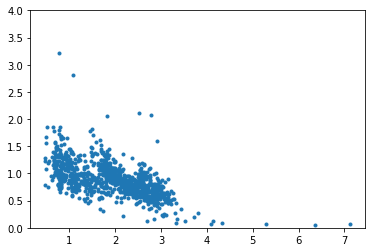

In [24]:
plt.plot(df10['E_ex_t']/df10['E_s_t'],df10['dE_ic'],'.')
plt.ylim(0,4)

In [25]:
df10['X_Mg_0'].describe()

count    1068.000000
mean        0.016495
std         0.013444
min         0.000010
25%         0.000010
50%         0.010008
75%         0.030004
max         0.040002
Name: X_Mg_0, dtype: float64

In [26]:
# cvals = (df10['T_cmb0']-5000)/1000
cvals = (df10['X_Mg_0'])/.04
colors= plt.cm.rainbow(cvals)

(0, 4)

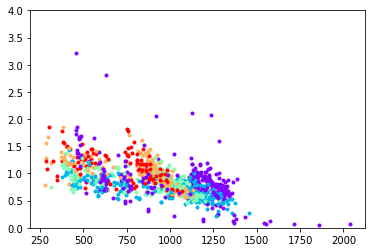

In [27]:
for x,y,c in zip(df10['E_ex_t'],df10['dE_ic'],colors):
    plt.plot(x,y,'.',color=c)

plt.ylim(0,4)

(0, 4)

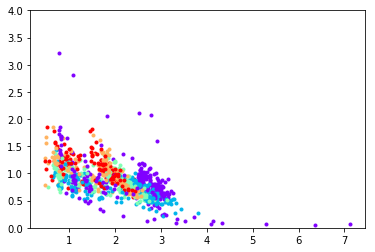

In [28]:
for x,y,c in zip(df10['E_ex_t']/df10['E_s_t'],df10['dE_ic'],colors):
    plt.plot(x,y,'.',color=c)

plt.ylim(0,4)

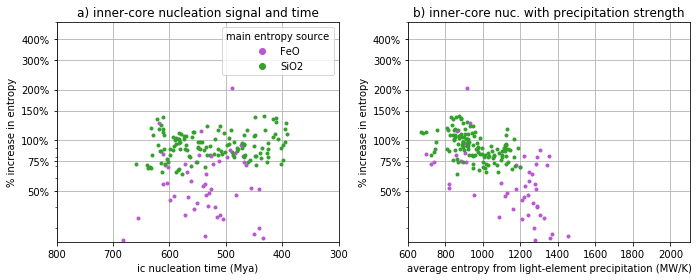

In [157]:
df = df10
df = df[df['wt_O_p']<=10]
df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]



plt.figure(figsize=(10,4))
plt.subplot(121)


lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(4560-df['t_ic']/Myrs,df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=1)
plt.xlabel('ic nucleation time (Mya)')
plt.ylabel('% increase in entropy')
plt.title('a) inner-core nucleation signal and time')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)
plt.xlim(800,300)
plt.legend(handles=lpatchs[::2], title='main entropy source',)


plt.subplot(122)

# df = df[df['in_BadroSeismicPresent']==True]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_ex_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=1)
plt.xlabel('average entropy from light-element precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('b) inner-core nuc. with precipitation strength')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)


plt.tight_layout()
plt.savefig('ic_info_Hirose.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

(0, 5)

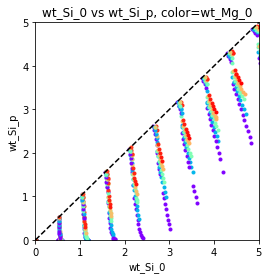

In [29]:
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_0'

cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


(0, 5)

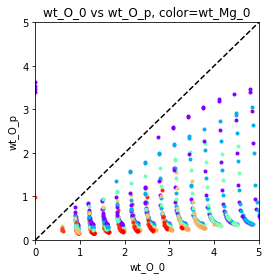

In [30]:
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


# Initial Constraints (Fischer)

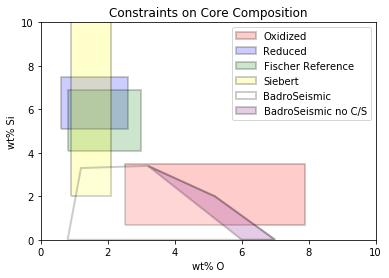

In [136]:
FischerOxidizedPath = mplPath.Path(np.array([(2.5,.7),(2.5,3.5),(7.9,3.5),(7.9,.7),(2.5,.7)]))
FischerReducedPath = mplPath.Path(np.array([(.6,5.1),(.6,7.5),(2.6,7.5),(2.6,5.1),(.6,5.1)]))
FischerReferencePath = mplPath.Path(np.array([(.8,4.1),(3,4.1),(3,6.9),(.8,6.9),(.8,4.1)]))

SiebertOSiPath = mplPath.Path(np.array([(.9,2),(2.1,2),(2.1,13),(.9,13),(.9,2)]))

BadroSeismicOSiPath = mplPath.Path(np.array([[0.8, 0. ],
       [1.2, 3.3],
       [3.2, 3.4],
       [5.2, 2. ],
       [7. , 0. ],[0.8, 0. ]]), None)
BadroSeismicOSinoCSPath = mplPath.Path(np.array([[6, 0. ],
       [3.2, 3.4],
       [5.2, 2. ],
       [7. , 0. ],[6, 0. ]]), None)
plt.figure()
ax = plt.subplot(111)
patch = patches.PathPatch(FischerOxidizedPath, lw=2., facecolor='red',alpha=.2,label='Oxidized')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Fischer Reference')
ax.add_patch(patch)
patch = patches.PathPatch(SiebertOSiPath, lw=2., facecolor='yellow', alpha=.2,label='Siebert')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSiPath, lw=2., facecolor='white', alpha=.2,label='BadroSeismic')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, lw=2., facecolor='purple', alpha=.2,label='BadroSeismic no C/S')
ax.add_patch(patch)
plt.xlim(0,10)
plt.ylim(0,10)
plt.legend()
plt.title('Constraints on Core Composition')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.savefig('core constraints.pdf')

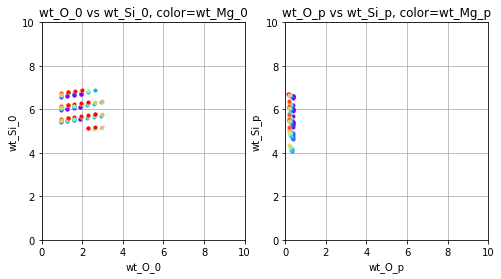

In [36]:
# Initial contraints (Fischer 2015)
df = df10[df10['wt_O_0']<=3]
df = df[df['wt_O_0']>=.8]
df = df[df['wt_Si_0']<=6.9]
df = df[df['wt_Si_0']>=5.1]
df = df[df['T_cmb0']>=5600]

plt.figure(figsize=(8,4))
plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'wt_Mg_0'
cvals = (df[cvar])/np.max(df[cvar])
colors= plt.cm.rainbow(cvals)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'.',color=c)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()

plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_p'
cvals = (df[cvar])/np.max(df[cvar])
colors= plt.cm.rainbow(cvals)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'.',color=c)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()

# Oxidized Initial and Final Constraints (Fischer and Badro)

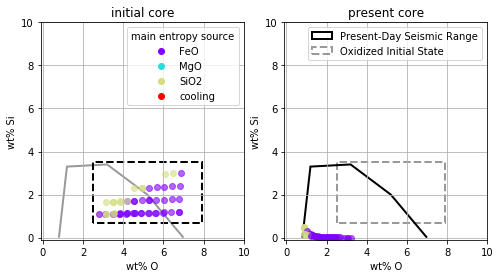

In [37]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=7]
df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=3.3]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[df['in_BadroSeismicPresent']==True]
df = df[df['in_FischerOxidizedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
# ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
# ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
plt.savefig('Initial_Final_core_composition_Hirose.pdf')

# Reference Initial and Final Constraints (Fischer and Badro)

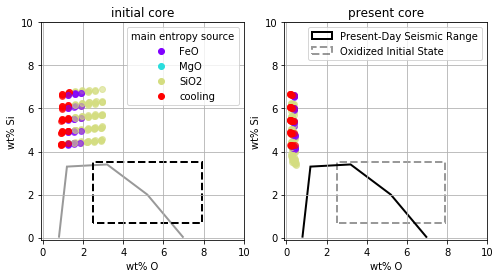

In [55]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=10]
# df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=10]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

# df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
# ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
# ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
plt.savefig('Initial_Final_core_composition_HiroseVals_FischerReferenceInit.pdf')

# Reduced Initial and Final Constraints (Fischer and Badro)

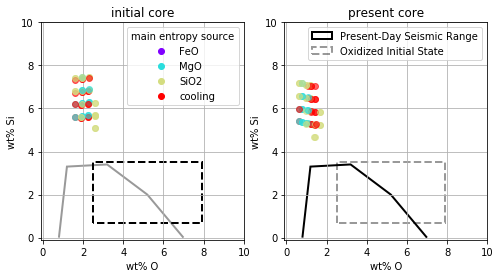

In [375]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=10]
# df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=10]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

# df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
df = df[df['in_FischerReducedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
# ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
# ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
# plt.savefig('Initial_Final_core_composition.pdf')

# Final Constraints (Badro)

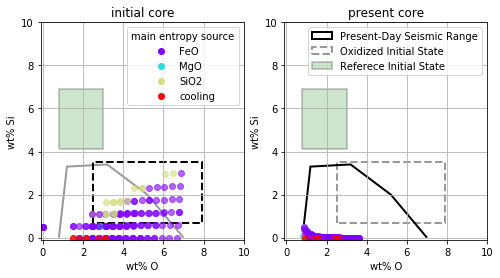

In [56]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=10]
# df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=10]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
plt.savefig('Initial_Final_core_composition_BadroSeismicFinalPlotted.pdf')

(0, 5)

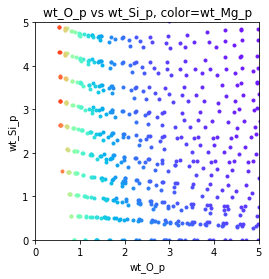

In [251]:
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_p'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


In [486]:
mpl.colors.cnames

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3

In [508]:
mpl.colors.hex2color('#00BFFF')

(0.0, 0.7490196078431373, 1.0)

In [99]:
cnames = ['FeO','MgO','SiO2','cooling']

def get_color(cname):
    cnames = ['FeO','MgO','SiO2','cooling']
    coolcolor = (1,0,0,1)
    scolor = (0.2, 0.6274509803921569, 0.17254901960784313,1)
    fcolor  = (0.7294117647058823, 0.3333333333333333, 0.8274509803921568,1)
    mcolor = (0.0, 0.7490196078431373, 1.0,1)
    colors = [fcolor,mcolor,scolor, coolcolor]
    return colors[cnames.index(cname)]

def maxE_color(df, cvar='maxE'):
    cvals = df[cvar].fillna('FeO')
    colors = np.array([get_color(v) for v in cvals])
    colors[df[cvar].isnull()] = (1,1,1,0)    
    return colors

# Oxidized Initial and Final Constraints (Fischer and Badro)

In [39]:
df = df[df['maxE']=='SiO2']


In [40]:
df['deltawtO'] = df['wt_O_0']-df['wt_O_p']

In [41]:
df['deltawtSi'] = df['wt_Si_0']-df['wt_Si_p']

In [42]:
df['deltawtMg'] = df['wt_Mg_0']-df['wt_Mg_p']

In [43]:
df[['deltawtO','deltawtSi','deltawtMg']].describe()

,deltawtO,deltawtSi,deltawtMg
count,16.000000,16.000000,16.000000
mean,3.125550,1.456716,0.328686
std,1.093349,0.552180,0.367808
min,1.838608,0.848332,-0.000111
25%,2.392074,0.987244,-0.000051
50%,2.725636,1.316410,0.380811
75%,3.753610,1.826828,0.427447
max,5.538396,2.639134,1.214789


In [119]:
mpl.colors.to_rgb('lime')

(0.0, 1.0, 0.0)

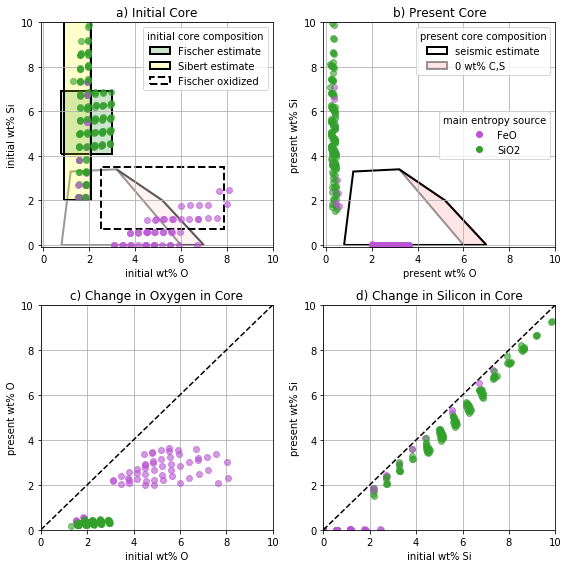

In [158]:
# Present-day constraints (Badro seismic model)
alpha = .6

df = df10
df = df[df['wt_O_p']<=10]
df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]


ymax = 10
plt.figure(figsize=(8,8))
ax = plt.subplot(221)

colors = maxE_color(df)

patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,0,0,.05))
ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., ec=(0,0,0,1), fc=(0,.5,0,.2),label='Fischer estimate')
ax.add_patch(patch)
patch = patches.PathPatch(SiebertOSiPath, lw=2., ec=(0,0,0,1), fc=(1,1,0,.2),label='Sibert estimate')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0),label='Fischer oxidized')
ax.add_patch(patch)

plt.legend(title='initial core composition')
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)

plt.xlabel('initial wt% O')
plt.ylabel('initial wt% Si')
plt.title('a) Initial Core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()


ax = plt.subplot(222)

patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='seismic estimate')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,0,0,.1), label='0 wt% C,S')
ax.add_patch(patch)

leg2 = plt.legend(loc='upper right', title='present core composition')

cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
leg1 = plt.legend(handles=lpatchs[::2], title='main entropy source', loc='center right')
plt.gca().add_artist(leg2)

xvar = 'wt_O_p'
yvar = 'wt_Si_p'
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)

plt.xlabel('present wt% O')
plt.ylabel('present wt% Si')
plt.title('b) Present Core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()

plt.subplot(223)
xvar = 'wt_O_0'
yvar = 'wt_O_p'
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c, alpha=alpha)
plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% O')
plt.ylabel('present wt% O')
plt.title('c) Change in Oxygen in Core')
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()

plt.subplot(224)
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c, alpha=alpha)
plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% Si')
plt.ylabel('present wt% Si')
plt.title('d) Change in Silicon in Core')
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()

plt.tight_layout()

plt.savefig('Core_composition_initfinal_4panel_OxidizedAndPreferred_Hirose.pdf')

In [526]:
np.mean(df['wt_O_0']-df['wt_O_p'])

1.102759724436925

In [527]:
np.mean(df['wt_Si_0']-df['wt_Si_p'])

0.5497767711965014

In [528]:
np.mean(df['wt_Mg_0']-df['wt_Mg_p'])

0.6414105553904517

# Figure 3 Plot for Nature

In [102]:
import matplotlib as mpl
from matplotlib import gridspec
def remove_outliers(t,y,percent=0.3, N=3):
    Nends = N-1
    yo = y + np.mean(y)*.1
#     non_outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(Nends*y[Nends//2:-Nends//2])-1) < percent)[0]+Nends//2
    non_outliers = np.where( np.abs((yo[:-Nends]+yo[Nends:])/(2*yo[Nends//2:-Nends//2]) - 1) < percent)[0]+Nends//2
    return t[non_outliers], y[non_outliers]

In [140]:
alldatafile

'all_parameters.m'

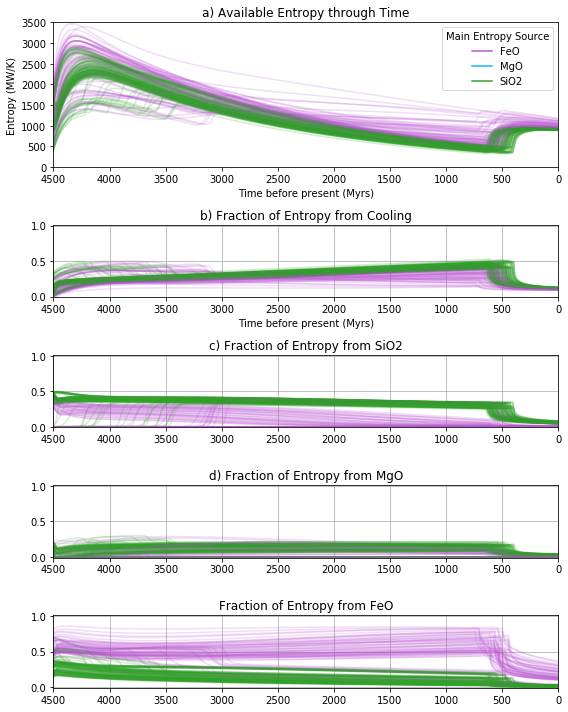

In [159]:
df = df10
df = df[df['wt_O_p']<=10]
df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]


Cent = 1e6
Myrs = 365.25*3600*24*1e6
alpha = 0.2
plt.figure(figsize=(8,10))
gs = gridspec.GridSpec(5, 1,height_ratios=(2,1,1,1,1)) 

ax = plt.subplot(gs[0])
Navg = 3
colors = []
Esifrac = []
Emgfrac = []
Efefrac = []
Ecoolfrac = []
colors = []
tplts = []

for i,row in df.iterrows():
    foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
    if not os.path.exists(datadir+foldername+alldatafile):
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        tn, allp = pl.core_layer.compute_all_parameters(times, solution)
        dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
    else:
        tn, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
    allp.Eex = allp.Egm + allp.Egs + allp.Egf
    allp.Eic = allp.Eg + allp.El
#     cvals = row['maxE'].fillna('FeO')
    cnames = ['FeO','MgO','SiO2','cooling']
    color = get_color(row['maxE'])
#     cvalsn = np.array([cnames.index(v)/3 for v in cvals])
    tn = tn[-1]-tn
    tp,ep = remove_outliers(tn,allp.Ephi,N=5,percent=.02)
    Ct = 3.17e7*1e6
    plt.plot(tp/Ct,ep/1e6, '-',color=color, alpha=alpha)
    tplts.append(tn/Ct)
    Etot = allp.Ephi+allp.Ek
    Esifrac.append(allp.Egs/Etot)
    Emgfrac.append(allp.Egm/Etot)
    Efefrac.append(allp.Egf/Etot)
    Ecoolfrac.append(allp.Es/Etot)
    colors.append(color)

fline = mpl.lines.Line2D([],[],color=get_color('FeO'),label='FeO')
mline = mpl.lines.Line2D([],[],color=get_color('MgO'),label='MgO')
sline = mpl.lines.Line2D([],[],color=get_color('SiO2'),label='SiO2')
coolline = mpl.lines.Line2D([],[],color=get_color('cooling'),label='cooling')

plt.legend(loc='upper right',handles=[fline,mline,sline], title='Main Entropy Source')
plt.ylim(0,3500)
plt.xlim(4500,0)
plt.xlabel('Time before present (Myrs)')
plt.ylabel('Entropy (MW/K)')
plt.title('a) Available Entropy through Time')
# plt.grid()

ax = plt.subplot(gs[1])
for t,e,c in zip(tplts,Ecoolfrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('b) Fraction of Entropy from Cooling')
plt.grid()
plt.xlabel('Time before present (Myrs)')

ax = plt.subplot(gs[2])
for t,e,c in zip(tplts,Esifrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('c) Fraction of Entropy from SiO2')
plt.grid()
# plt.xlabel('Time before present (Myrs)')

ax = plt.subplot(gs[3])
for t,e,c in zip(tplts,Emgfrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('d) Fraction of Entropy from MgO')
plt.grid()
# plt.xlabel('Time before present (Myrs)')

ax = plt.subplot(gs[4])
for t,e,c in zip(tplts,Efefrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('Fraction of Entropy from FeO')
plt.grid()

plt.tight_layout()
plt.savefig('figure3_Hirose_SiOMgOcooling.pdf')

# Old Plots

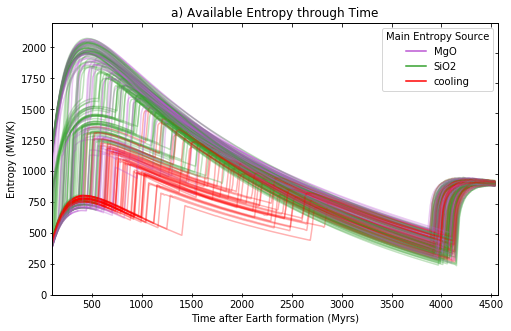

In [500]:
Cent = 1e6
Myrs = 365.25*3600*24*1e6
alpha = 0.3
plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(1, 1) 

ax = plt.subplot(gs[0])
Navg = 3
colors = []
Esifrac = []
Emgfrac = []
Efefrac = []
Ecoolfrac = []
for i,row in df.iterrows():
    foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
    if not os.path.exists(datadir+foldername+alldatafile):
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        tp, allp = pl.core_layer.compute_all_parameters(times, solution)
        dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
    else:
        tp, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
    allp.Eex = allp.Egm + allp.Egs + allp.Egf
    allp.Eic = allp.Eg + allp.El
#     cvals = row['maxE'].fillna('FeO')
    cnames = ['FeO','MgO','SiO2','cooling']
    color = get_color(row['maxE'])
#     cvalsn = np.array([cnames.index(v)/3 for v in cvals])
    tp,ep = remove_outliers(tp,allp.Ephi,N=5,percent=.02)
    Ct = 3.17e7*1e6
    plt.plot(tp/Ct,ep/1e6, '-',color=color, alpha=alpha)
    Esifrac.append(allp.Egs/allp.Ephi)
    Emgfrac.append(allp.Egs/allp.Ephi)
    Efefrac.append(allp.Egs/allp.Ephi)
    Ecoolfrac.append(allp.Egs/allp.Ephi)
    
fline = mpl.lines.Line2D([],[],color=get_color('FeO'),label='FeO')
mline = mpl.lines.Line2D([],[],color=get_color('MgO'),label='MgO')
sline = mpl.lines.Line2D([],[],color=get_color('SiO2'),label='SiO2')
coolline = mpl.lines.Line2D([],[],color=get_color('cooling'),label='cooling')

plt.legend(loc='upper right',handles=[mline,sline,coolline], title='Main Entropy Source')
plt.ylim(0,2200)
plt.xlim(100,4.568e3)
plt.xlabel('Time after Earth formation (Myrs)')
plt.ylabel('Entropy (MW/K)')
plt.title('a) Available Entropy through Time')
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

(0, 5)

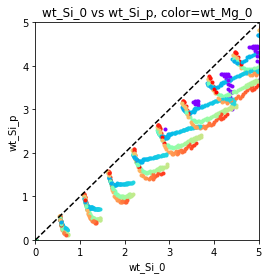

In [301]:
plt.subplot(223)
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_0'

cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)

plt.subplot(224)
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


In [457]:
tn[-1]

1.4392806681479037e+17

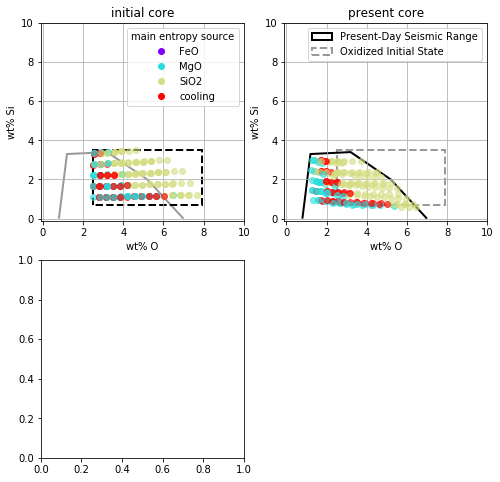

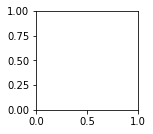

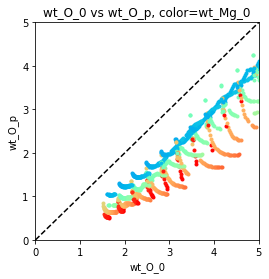

In [377]:
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()

plt.subplot(223)
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'

plt.figure(figsize=(4,4))
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)

plt.subplot(224)
xvar = 'wt_O_0'
yvar = 'wt_O_p'

plt.figure(figsize=(4,4))
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)
plt.savefig('Core_composition_initfinal_4panel_Oxidized_Fischer2015.pdf')

(0, 5)

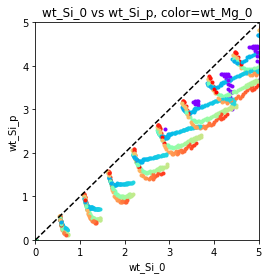

In [301]:
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_0'

cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


(0, 5)

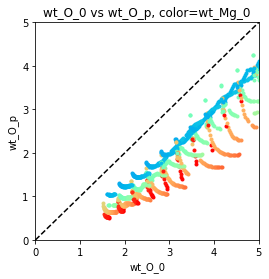

In [302]:
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


(0, 5)

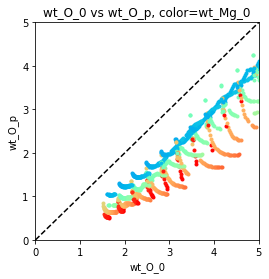

In [302]:
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)
